cpu
0.1 2.5
0.0 2.0
-10.0 -1.0
2.0 73.0
1.0 500.0
4.0 12.0
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.97e-02 | test_loss: 7.98e-02 | reg: 4.28e+01 | : 100%|█| 100/100 [00:11<00:00,  9.04


saving model version 0.1
MAE: 0.0552
MSE: 0.0064
MAPE: 0.2760
R²: 1.0000
RMSE: 0.0798
fixing (0,0,0) with log10, r2=0.999951183795929, c=1
fixing (0,0,1) with 0, r2=0.0, c=0
fixing (0,0,2) with 0, r2=0.0, c=0
fixing (0,0,3) with 0, r2=0.0, c=0
fixing (0,0,4) with 0, r2=0.0, c=0
fixing (0,0,5) with log10, r2=0.9998598098754883, c=1
fixing (0,1,0) with x, r2=0.9503376483917236, c=1
fixing (0,1,1) with log10, r2=0.9999734163284302, c=1
fixing (0,1,2) with exp, r2=0.9986336827278137, c=2
fixing (0,1,3) with 0, r2=0.0, c=0
fixing (0,1,4) with 0, r2=0.0, c=0
fixing (0,1,5) with cos, r2=0.9999915957450867, c=2
fixing (0,2,0) with 0, r2=0.0, c=0
fixing (0,2,1) with 0, r2=0.0, c=0
fixing (0,2,2) with 0, r2=0.0, c=0
fixing (0,2,3) with 0, r2=0.0, c=0
fixing (0,2,4) with 0, r2=0.0, c=0
fixing (0,2,5) with x, r2=0.9996246099472046, c=1
fixing (0,3,0) with 0, r2=0.0, c=0
fixing (0,3,1) with log10, r2=0.9992449283599854, c=1
fixing (0,3,2) with 0, r2=0.0, c=0
fixing (0,3,3) with 0, r2=0.0, c=0
fixin

9.005*x_3 + 8.008*x_6 + 0.016*(0.028*x_4 - 1)**2 - 291.519*log10(8.686 - 3.052*x_1) - 53.258*log10(9.367 - 3.859*x_5) + 32.175*cos(1.116*x_2 - 1.323) + 313.289 - 0.476/(-x_4 - 0.168)**2

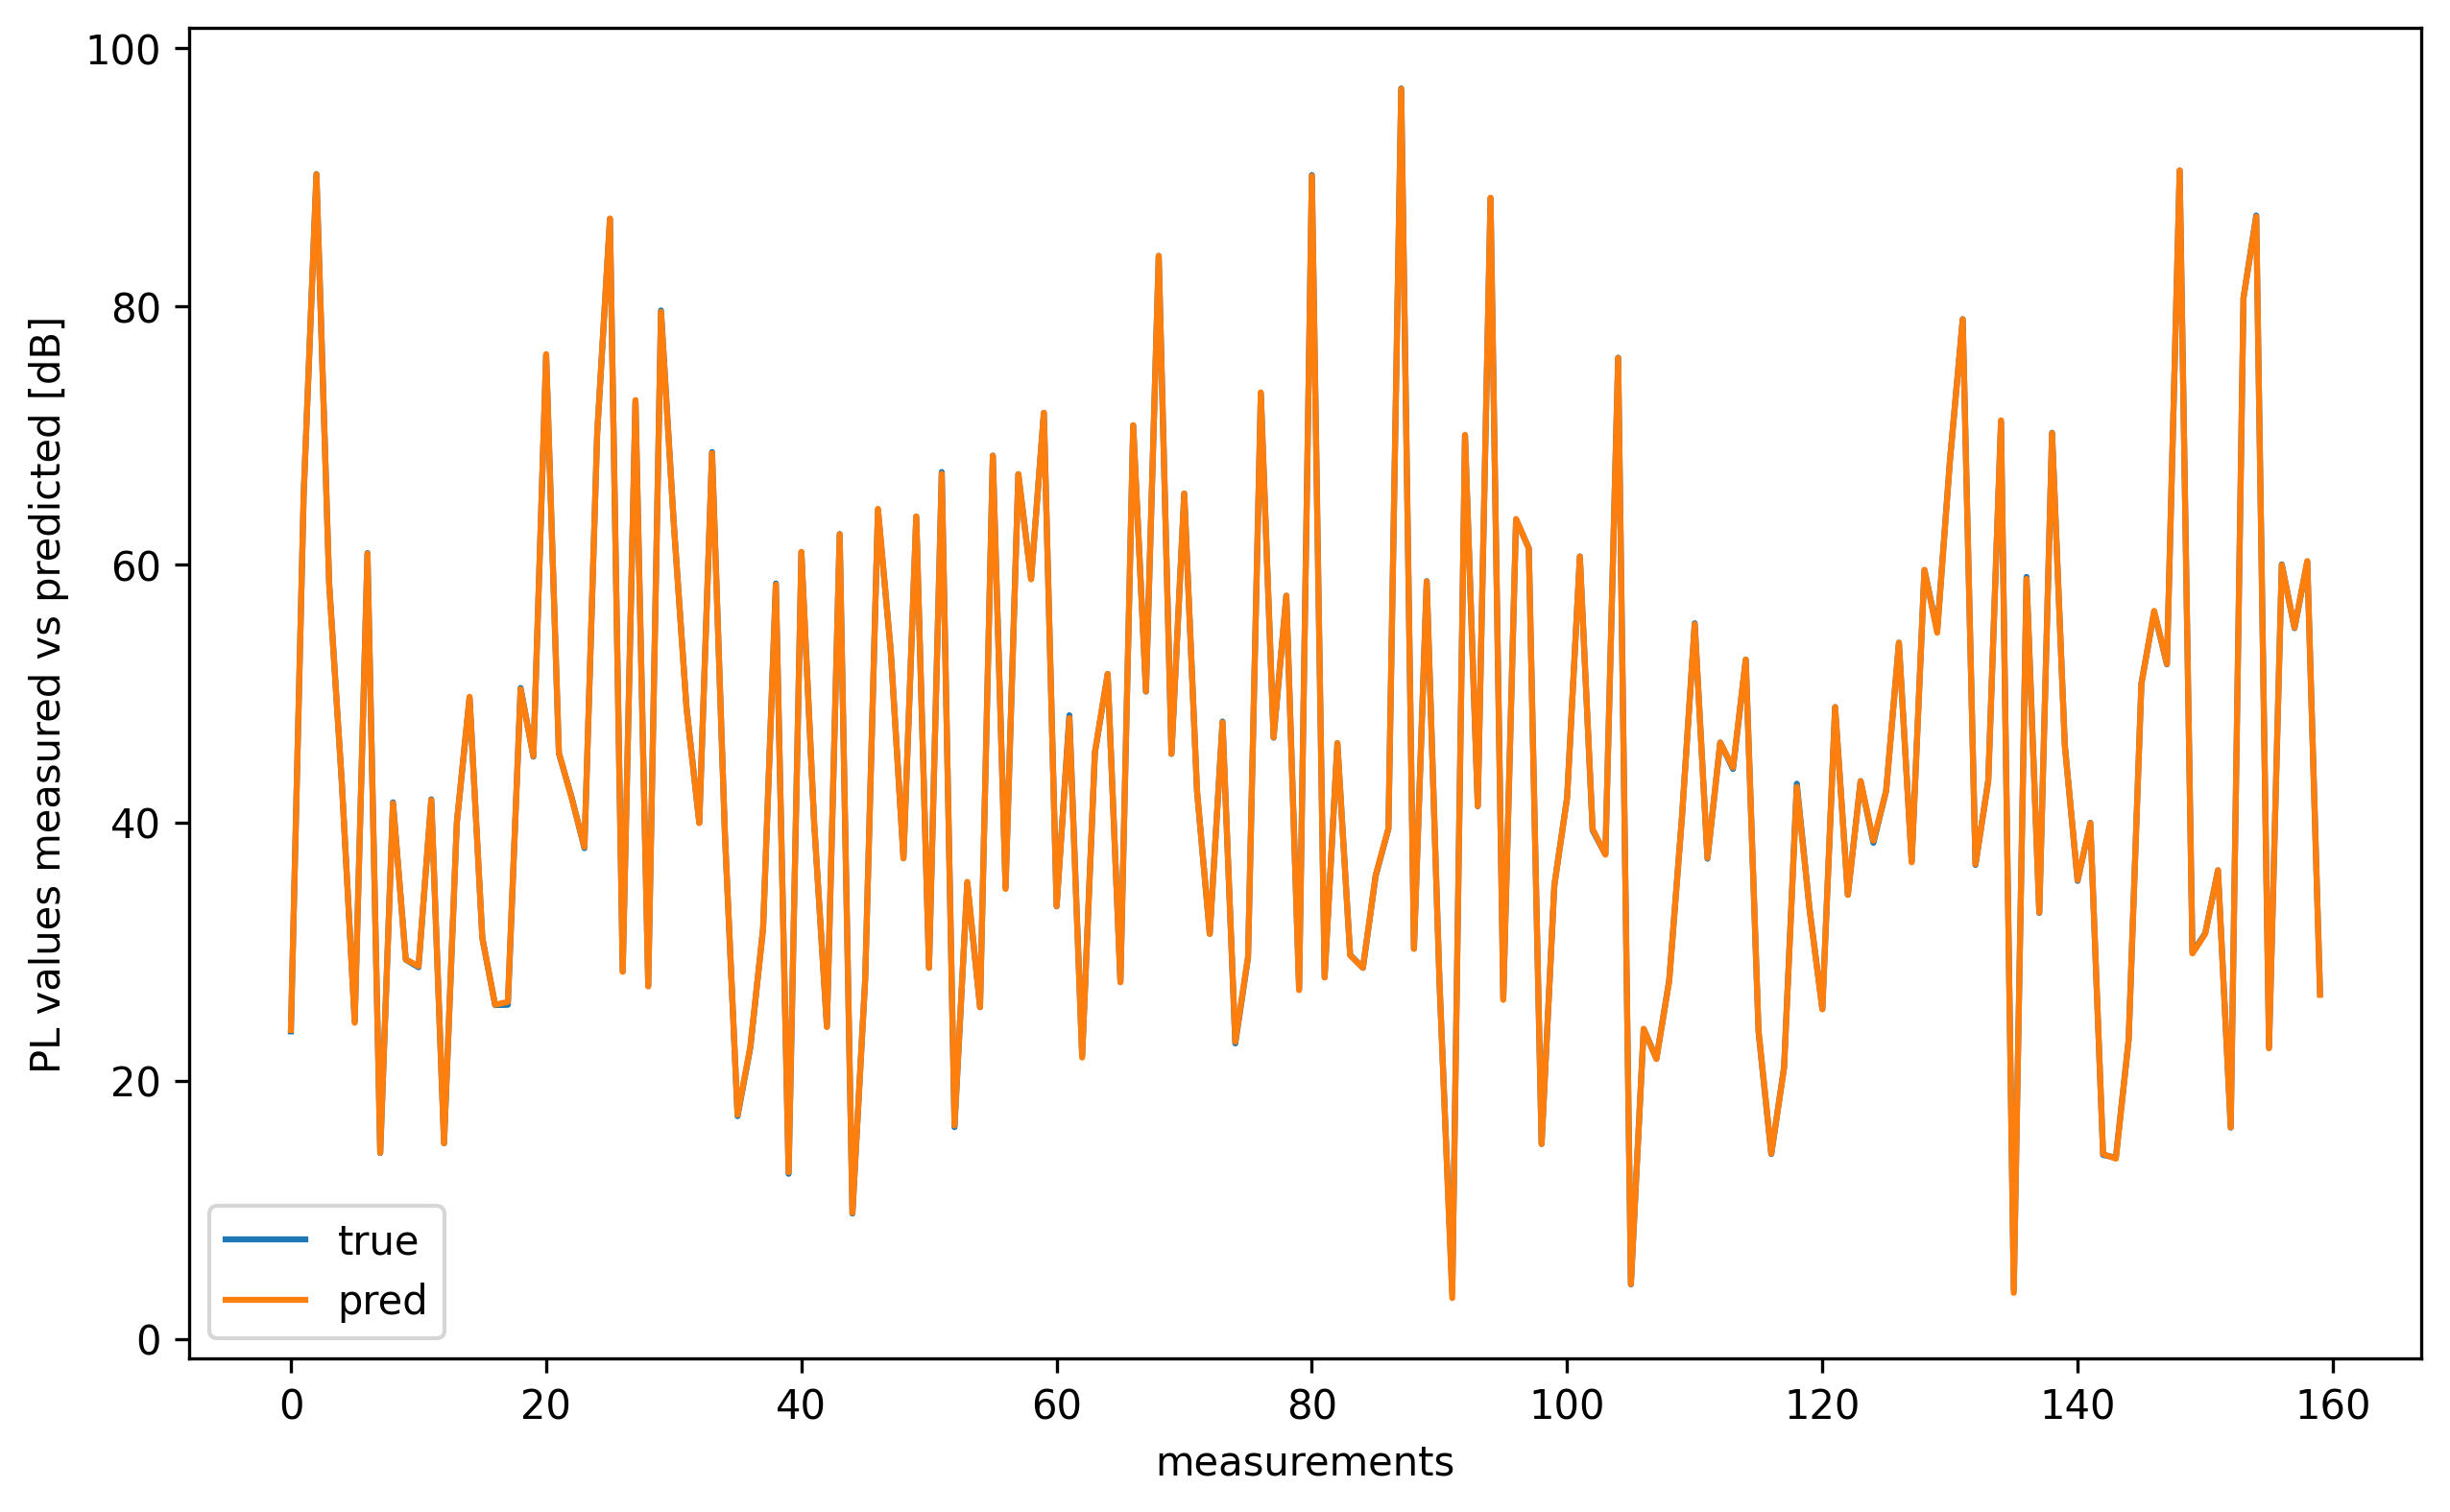

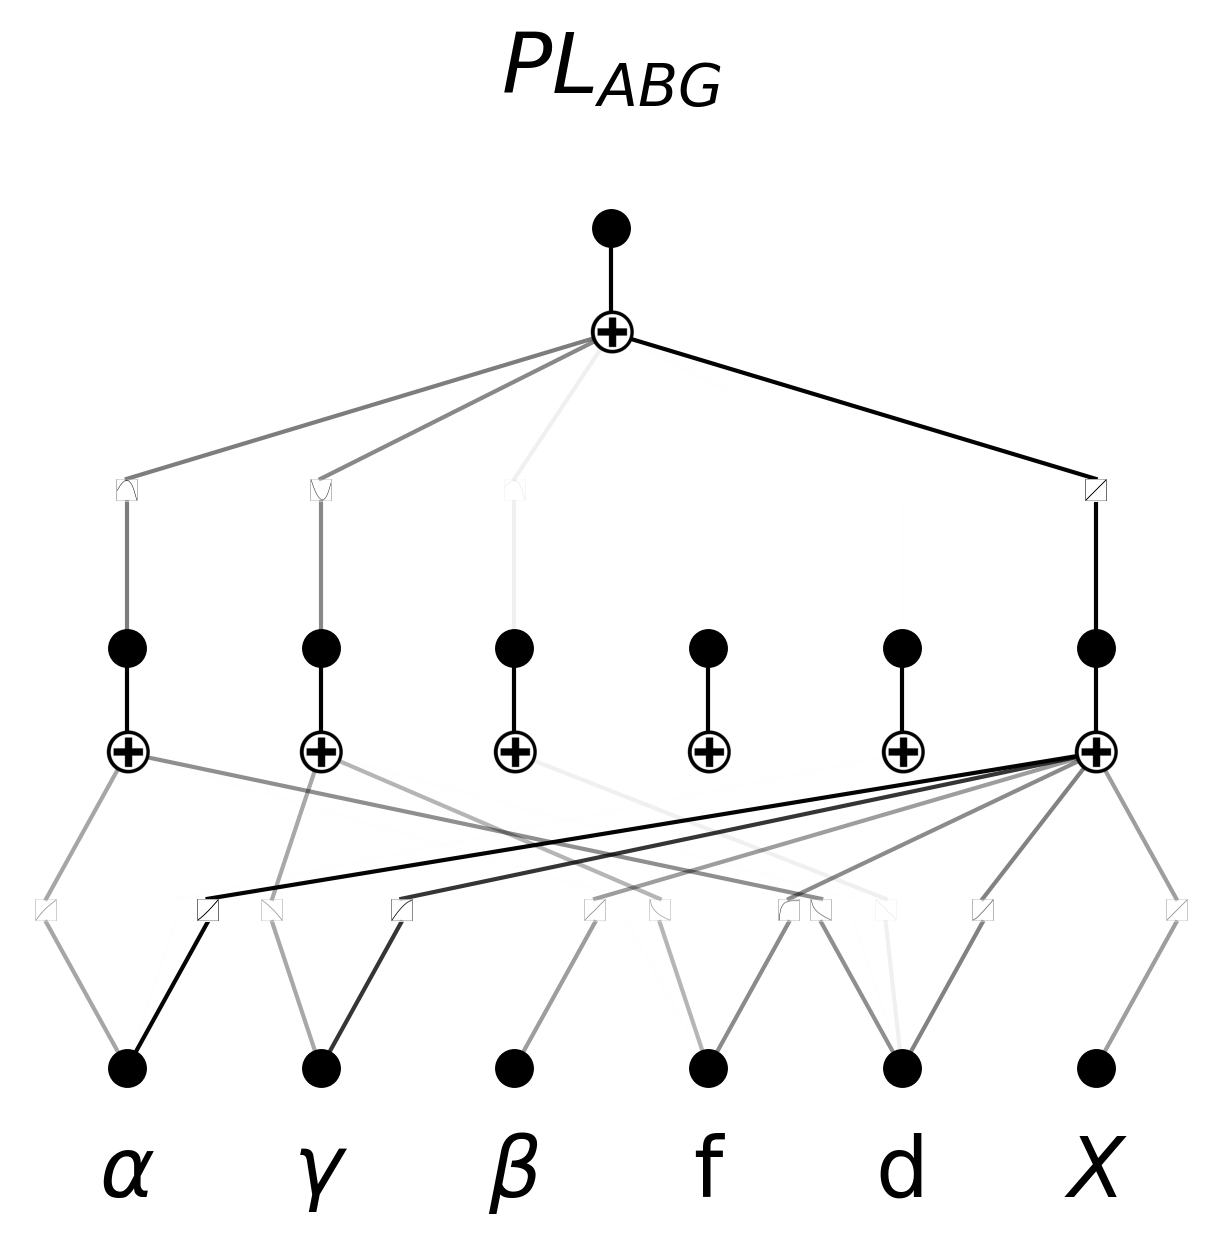

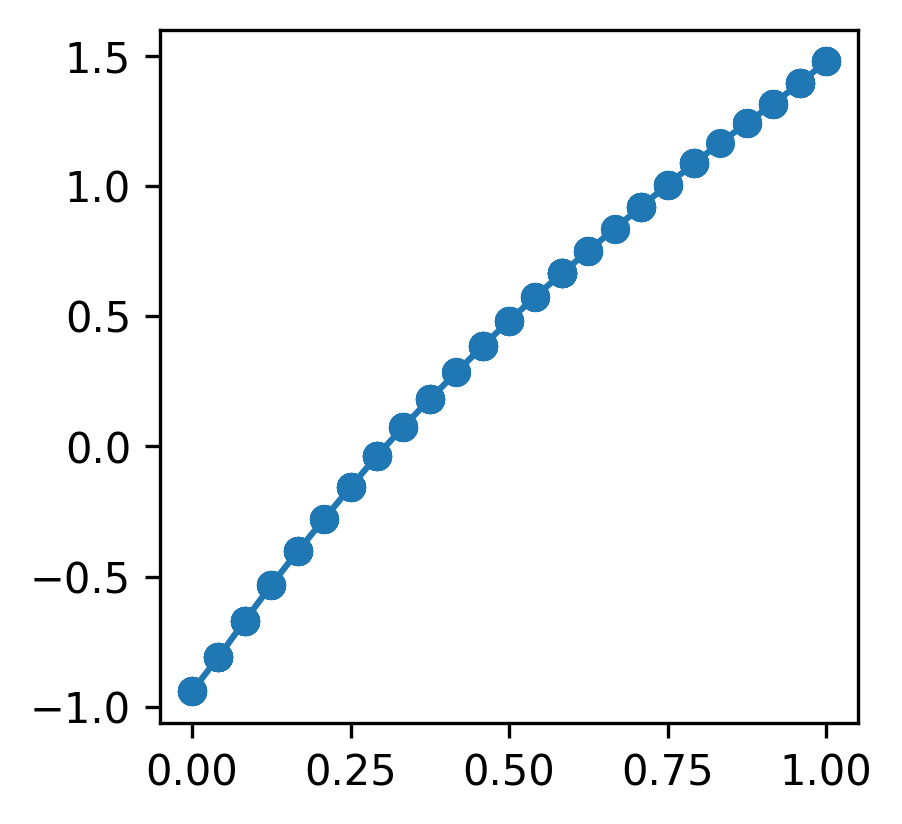

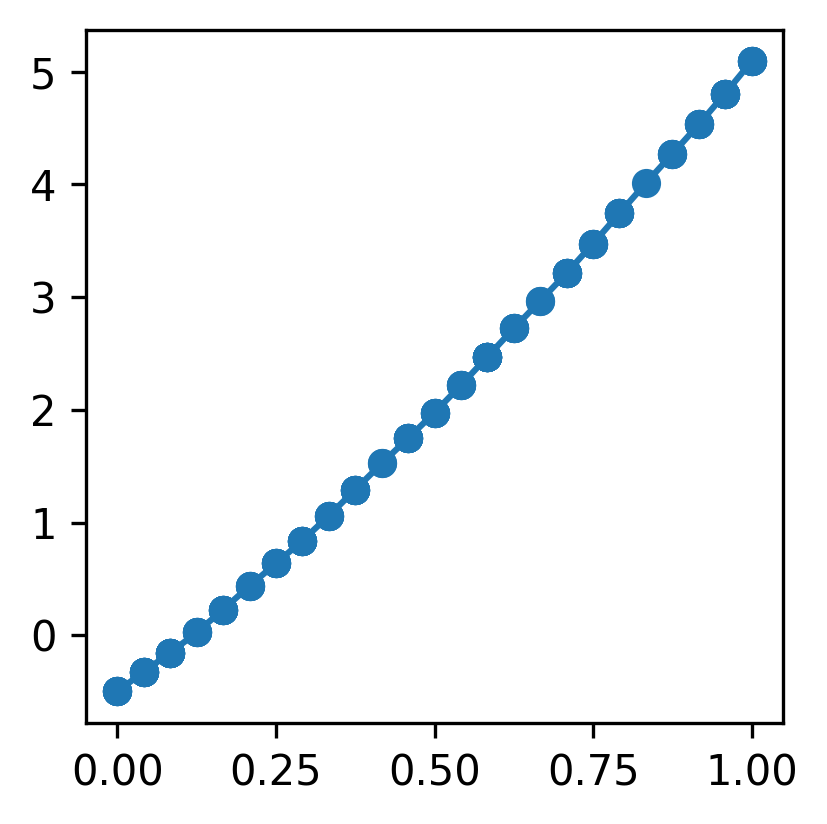

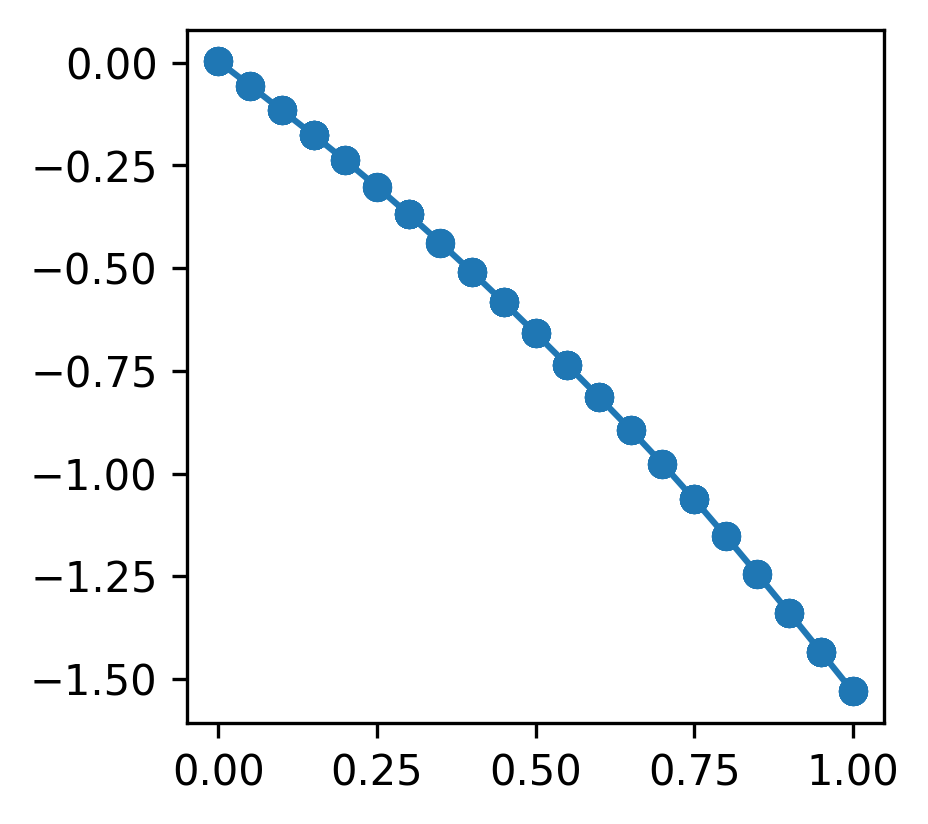

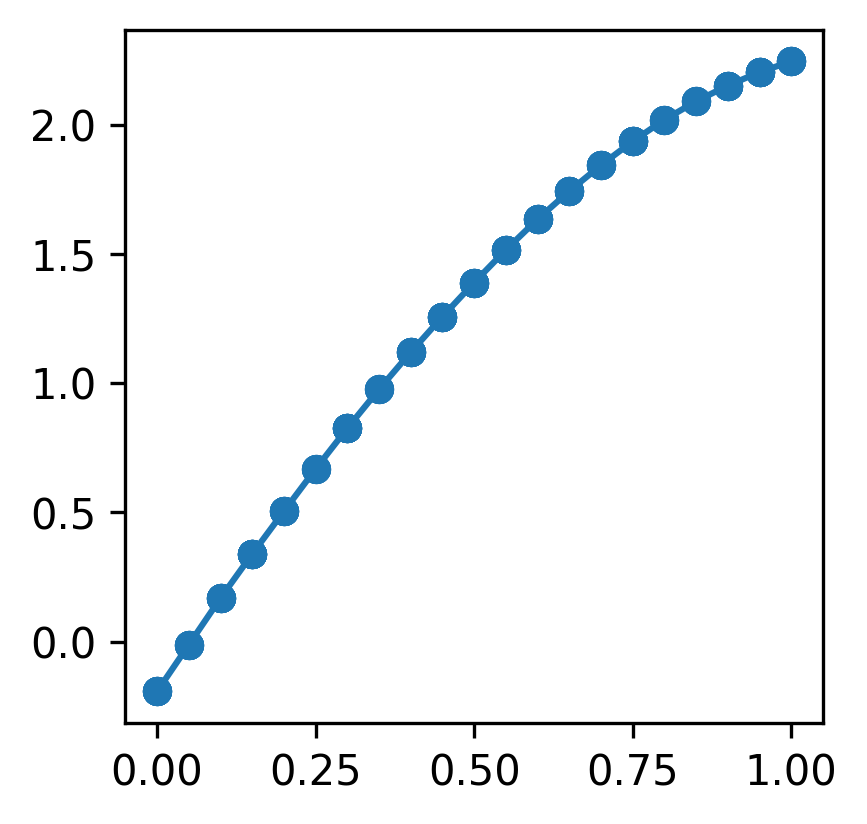

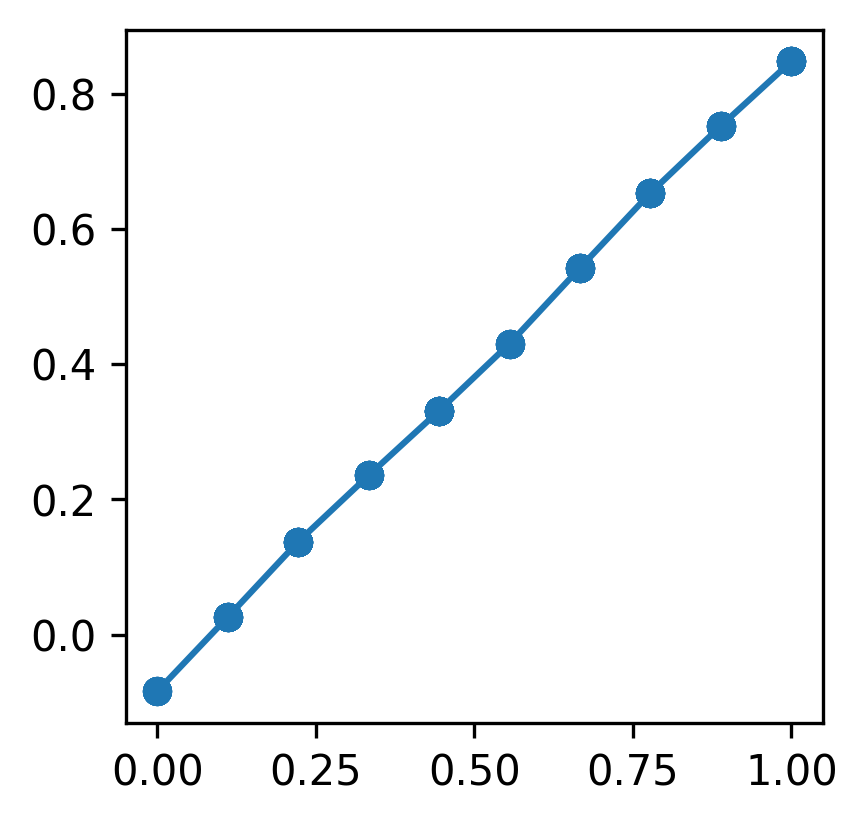

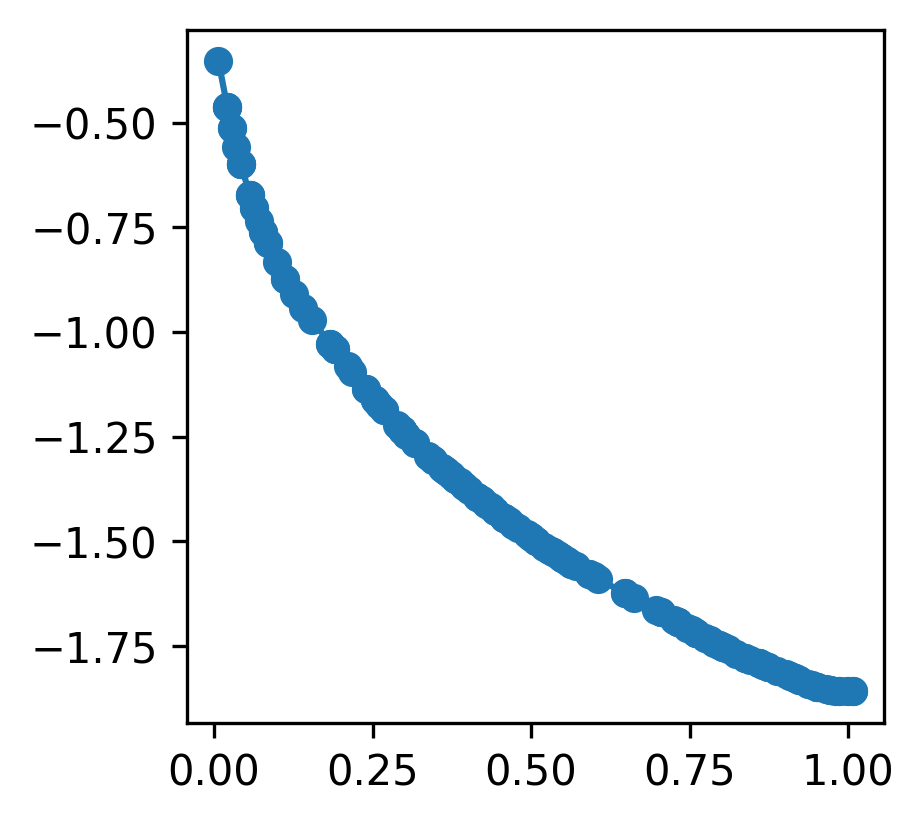

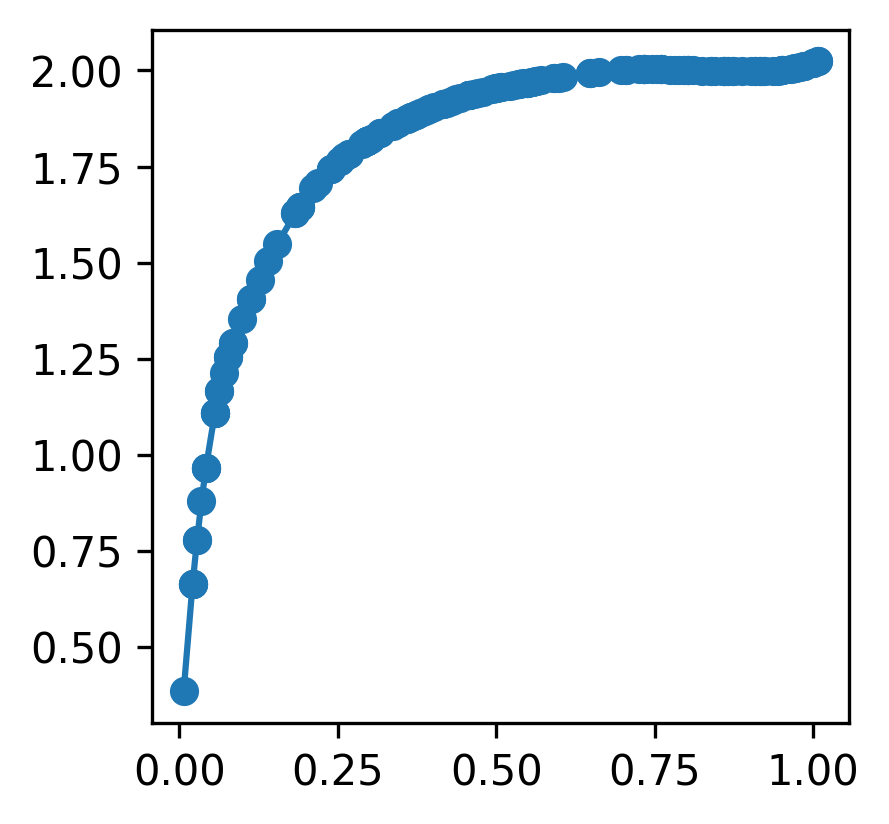

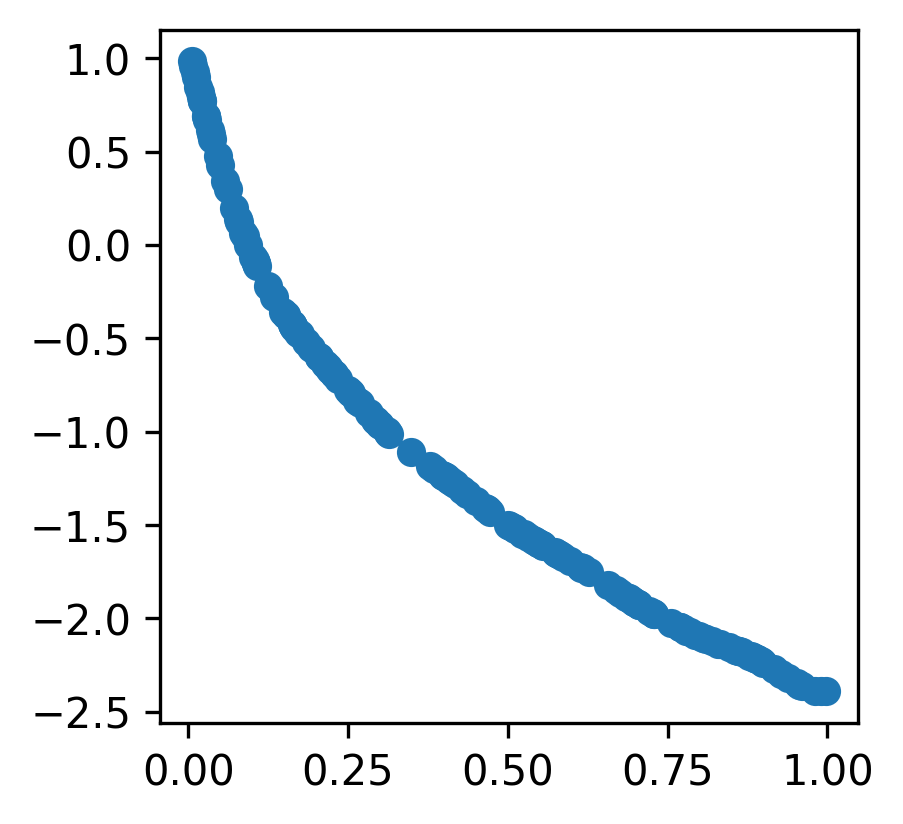

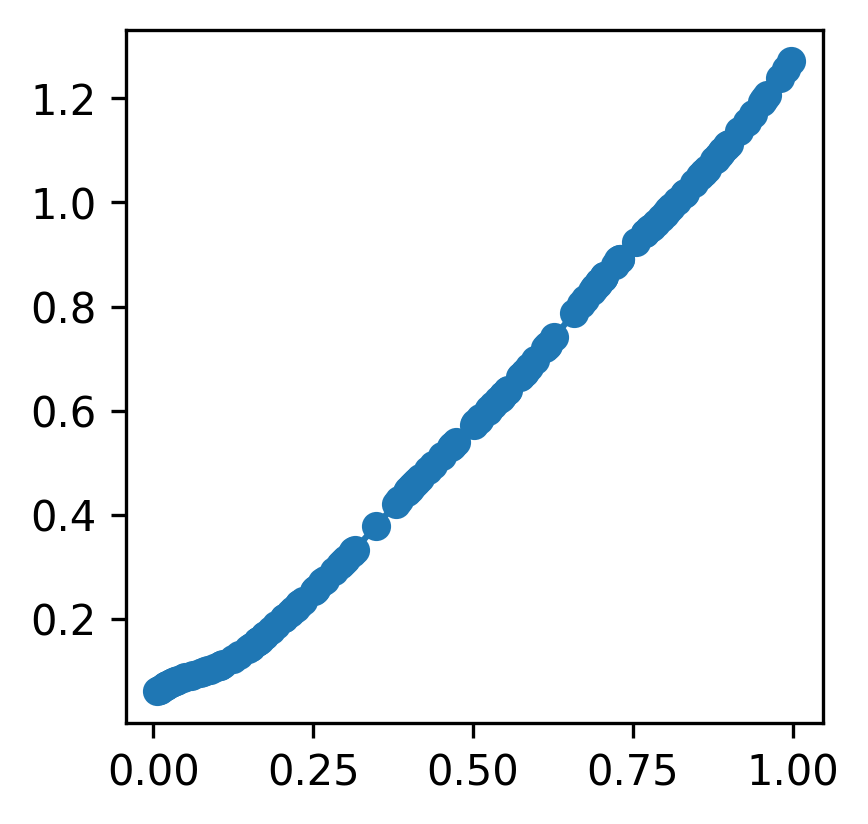

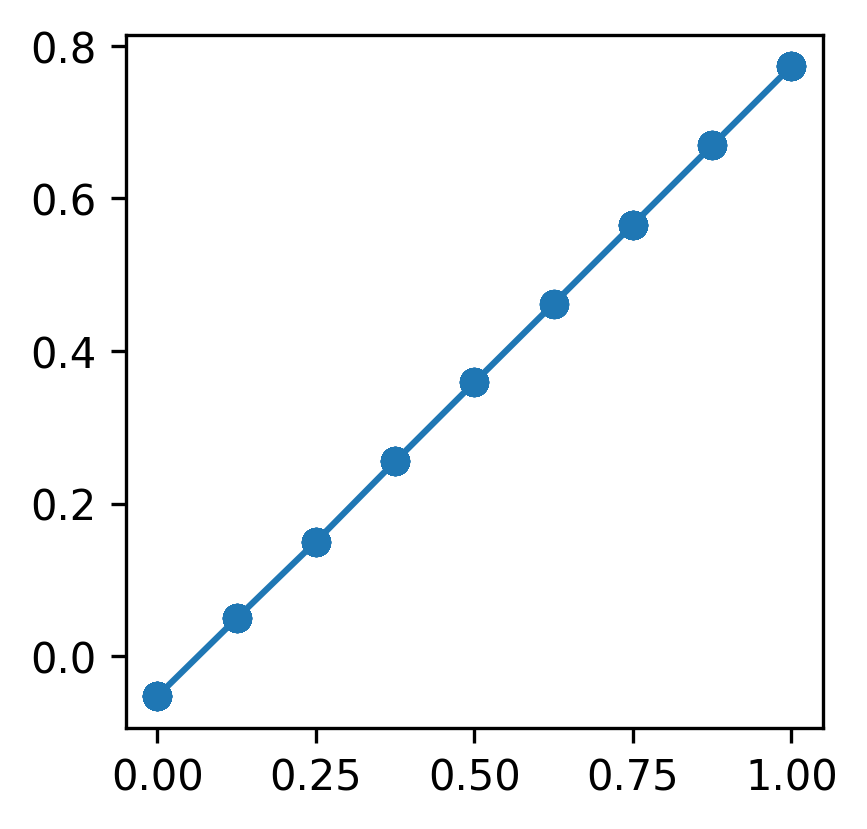

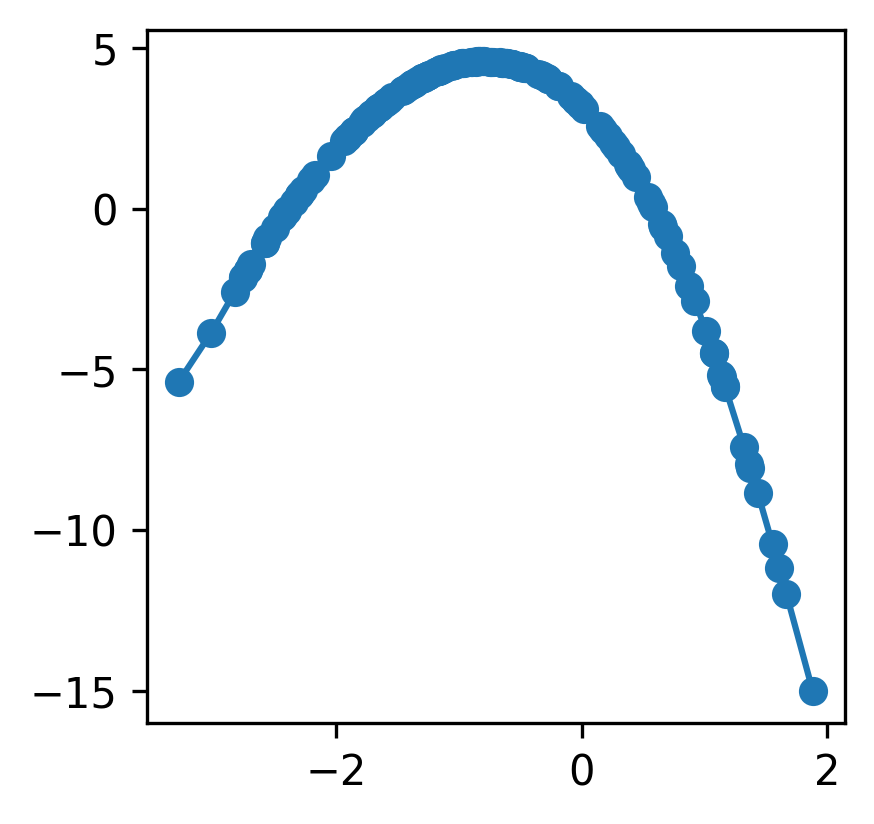

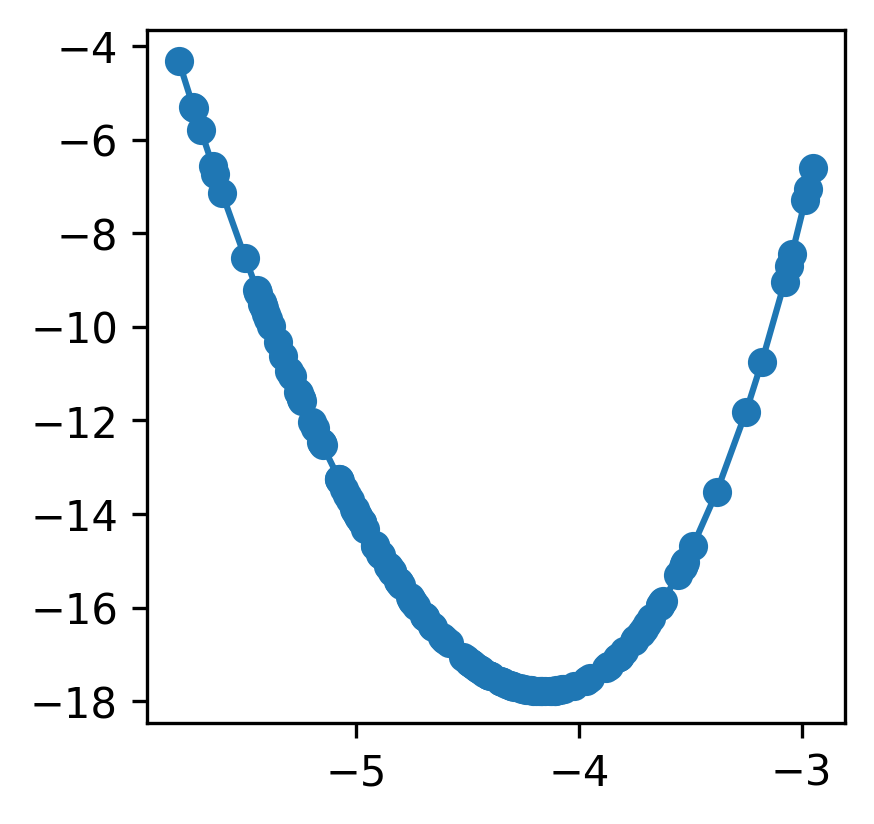

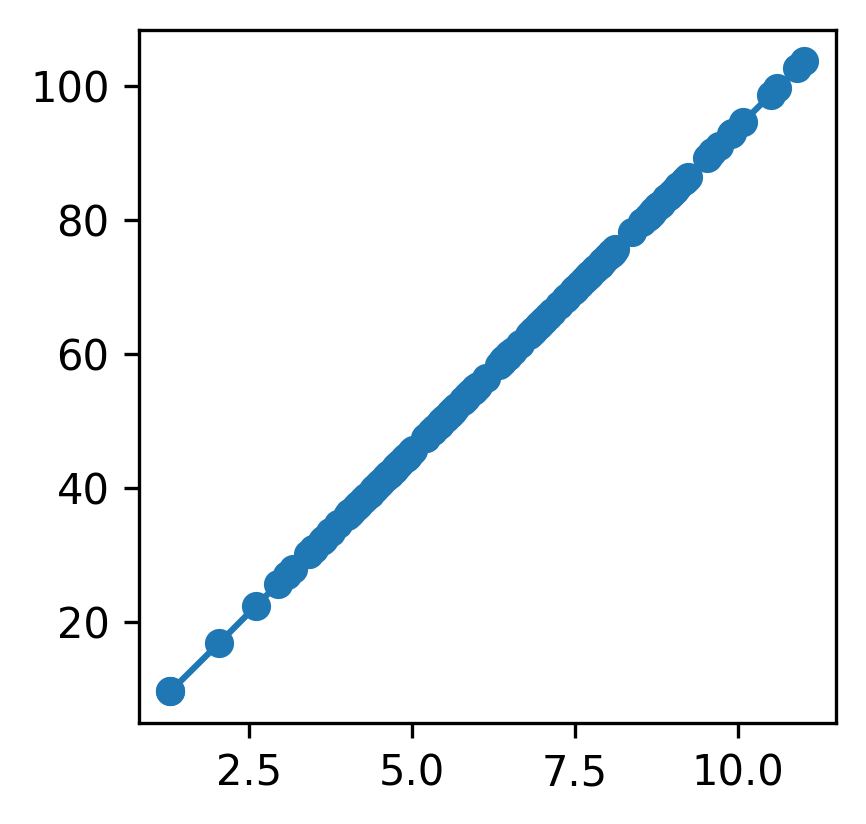

In [15]:

from kan import *
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


def eval_kan(model_kan, f, test_data):
    y_true = test_data['test_label']
    with torch.no_grad():
        y_pred = model_kan(test_data['test_input'])
        
    y_true = y_true.detach().cpu().numpy().ravel()[:250]
    y_pred = y_pred.detach().cpu().numpy().ravel()[:250]
    time = range(len(y_true))

    # Plot the training and test losses.
    plt.plot(time, y_true)
    plt.plot(time, y_pred)
    if f is not nan:
        y_symbolic = f(test_data['test_input'])[:250]
        plt.plot(time, y_symbolic)
        plt.legend(['true', 'pred', 'symbolic'])
    else:
        plt.legend(['true', 'pred'])
    plt.ylabel('PL values measured vs predicted [dB]')
    plt.xlabel('measurements')


    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    mape_frac = mean_absolute_percentage_error(y_true, y_pred)
    mape = mape_frac * 100
    
    # Print results
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return mse, rmse, mae, mape, r2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_gids_steps_lambda_loss(gids_size, steps, lam, metric, metric_name):
    """
    Plots a 3D scatter of gids_size vs steps vs train_loss, 
    with point color representing lambda.
    
    Parameters:
    - gids_size: array-like of shape (N,)
    - steps: array-like of shape (N,)
    - lam: array-like of shape (N,)
    - train_loss: array-like of shape (N,)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(gids_size, steps, lam, c=metric)
    
    ax.set_xlabel('gids size')
    ax.set_ylabel('steps')
    ax.set_zlabel('lambda')
    
    plt.colorbar(sc, label=metric_name)
    plt.title('3D Scatter: gids size vs steps vs lambda (' + metric_name + ' as color)')
    plt.show()


import re  # for extracting intervals

# Read the data from the Excel file
abg_data = pd.read_excel('Propagation_models.xlsx', sheet_name='ABG', header=0)

# First row contains normalization factors, let's store it
first_row = abg_data.iloc[0]

# Drop the first row after using it for normalization
abg_data = abg_data.drop(index=0)

# Clean column names by stripping whitespace
abg_data.columns = abg_data.columns.str.strip()

# Function to extract the interval from string or list (like "[x,y]" or [x, y])
def extract_interval(interval_value):
    # Ensure interval_value is a string, in case it's a sympy.Basic or other object
    interval_str = str(interval_value)
    
    if isinstance(interval_str, str):
        # Using regex to extract the values between the square brackets
        match = re.match(r'\[([0-9.-]+),\s*([0-9.-]+)\]', interval_str)
        if match:
            return float(match.group(1)), float(match.group(2))  # Return as a tuple (min, max)
        else:
            raise ValueError(f"Invalid interval format: {interval_str}")
    elif isinstance(interval_value, list) and len(interval_value) == 2:
        # Directly return the two values in the list as min and max
        return float(interval_value[0]), float(interval_value[1])
    else:
        raise ValueError(f"Invalid interval format: {interval_value}")

# Normalize the columns based on the first row
for col in ['alpha', 'gamma', 'beta', 'f', 'd', 'X']:
    # Extract the min and max values from the first row, whether it's a string or a list
    min_val, max_val = extract_interval(first_row[col])
    print(min_val, max_val)
    # Normalize the data using the extracted min and max
    abg_data[col] = (abg_data[col] - min_val) / (max_val - min_val)

# Convert specified columns to floats
for col in ['alpha', 'gamma', 'beta', 'f', 'd', 'X']:
    abg_data[col] = pd.to_numeric(abg_data[col], errors='coerce').astype(float)

# Check for any NaN values after conversion
if abg_data.isnull().any().any():
    print("Warning: NaN values detected in the dataset.")

# Assuming `inputs` and `labels` are your raw data as numpy arrays
inputs = abg_data[['alpha', 'gamma', 'beta', 'f', 'd', 'X']].values  # Input features (f, d, X, n)
labels = abg_data['PL_ABG'].values    # Output labels (PL_ABG)

# Split into 80% train + 20% test
train_val_input, test_input, train_val_label, test_label = train_test_split(
    inputs, labels, test_size=0.2, random_state=42
)

# Split the remaining 80% into 80% train + 20% validation
train_input, val_input, train_label, val_label = train_test_split(
    train_val_input, train_val_label, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
train_input = torch.tensor(train_input, dtype=torch.float32)
val_input = torch.tensor(val_input, dtype=torch.float32)

train_label = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
val_label = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

# Prepare the dataset dictionary
dataset = {
    'train_input': train_input,
    'test_input': val_input,
    'train_label': train_label,
    'test_label': val_label
}

# Develop the KAN model using a generic approach where the first 
# layers equal the number of inputs and the last the number of outputs
model = KAN(width=[6,6,1], grid=10, k=3, seed=42, device=device)

# this is the learnt KAN model (splines + edge weights)
model.fit(dataset, opt='LBFGS', steps=100, lamb=0.002);

eval_kan(model, nan, dataset)
model.plot(in_vars=[r'$\alpha$', r'$\gamma$', r'$\beta$', 'f', 'd', '$X$'], out_vars=['$PL_{ABG}$'])
x, y = model.get_fun(0,0,0)
x, y = model.get_fun(0,0,5)
x, y = model.get_fun(0,1,1)
x, y = model.get_fun(0,1,5)
x, y = model.get_fun(0,2,5)
x, y = model.get_fun(0,3,1)
x, y = model.get_fun(0,3,5)
x, y = model.get_fun(0,4,0)
x, y = model.get_fun(0,4,5)
x, y = model.get_fun(0,5,5)

x, y = model.get_fun(1,0,0)
x, y = model.get_fun(1,1,0)
x, y = model.get_fun(1,5,0)



# this is the symbolic approximation of the learnt splines with interpretable mathematical functions
add_symbolic('log10', torch.log10)
model.auto_symbolic()

ex_round(model.symbolic_formula()[0][0], 3)

MAE: 3.8854
MSE: 28.1364
MAPE: 12.5135
R²: 0.9315
RMSE: 5.3044


(28.136409759521484,
 np.float64(5.304376472265282),
 3.885438919067383,
 12.513473629951477,
 0.9315375685691833)

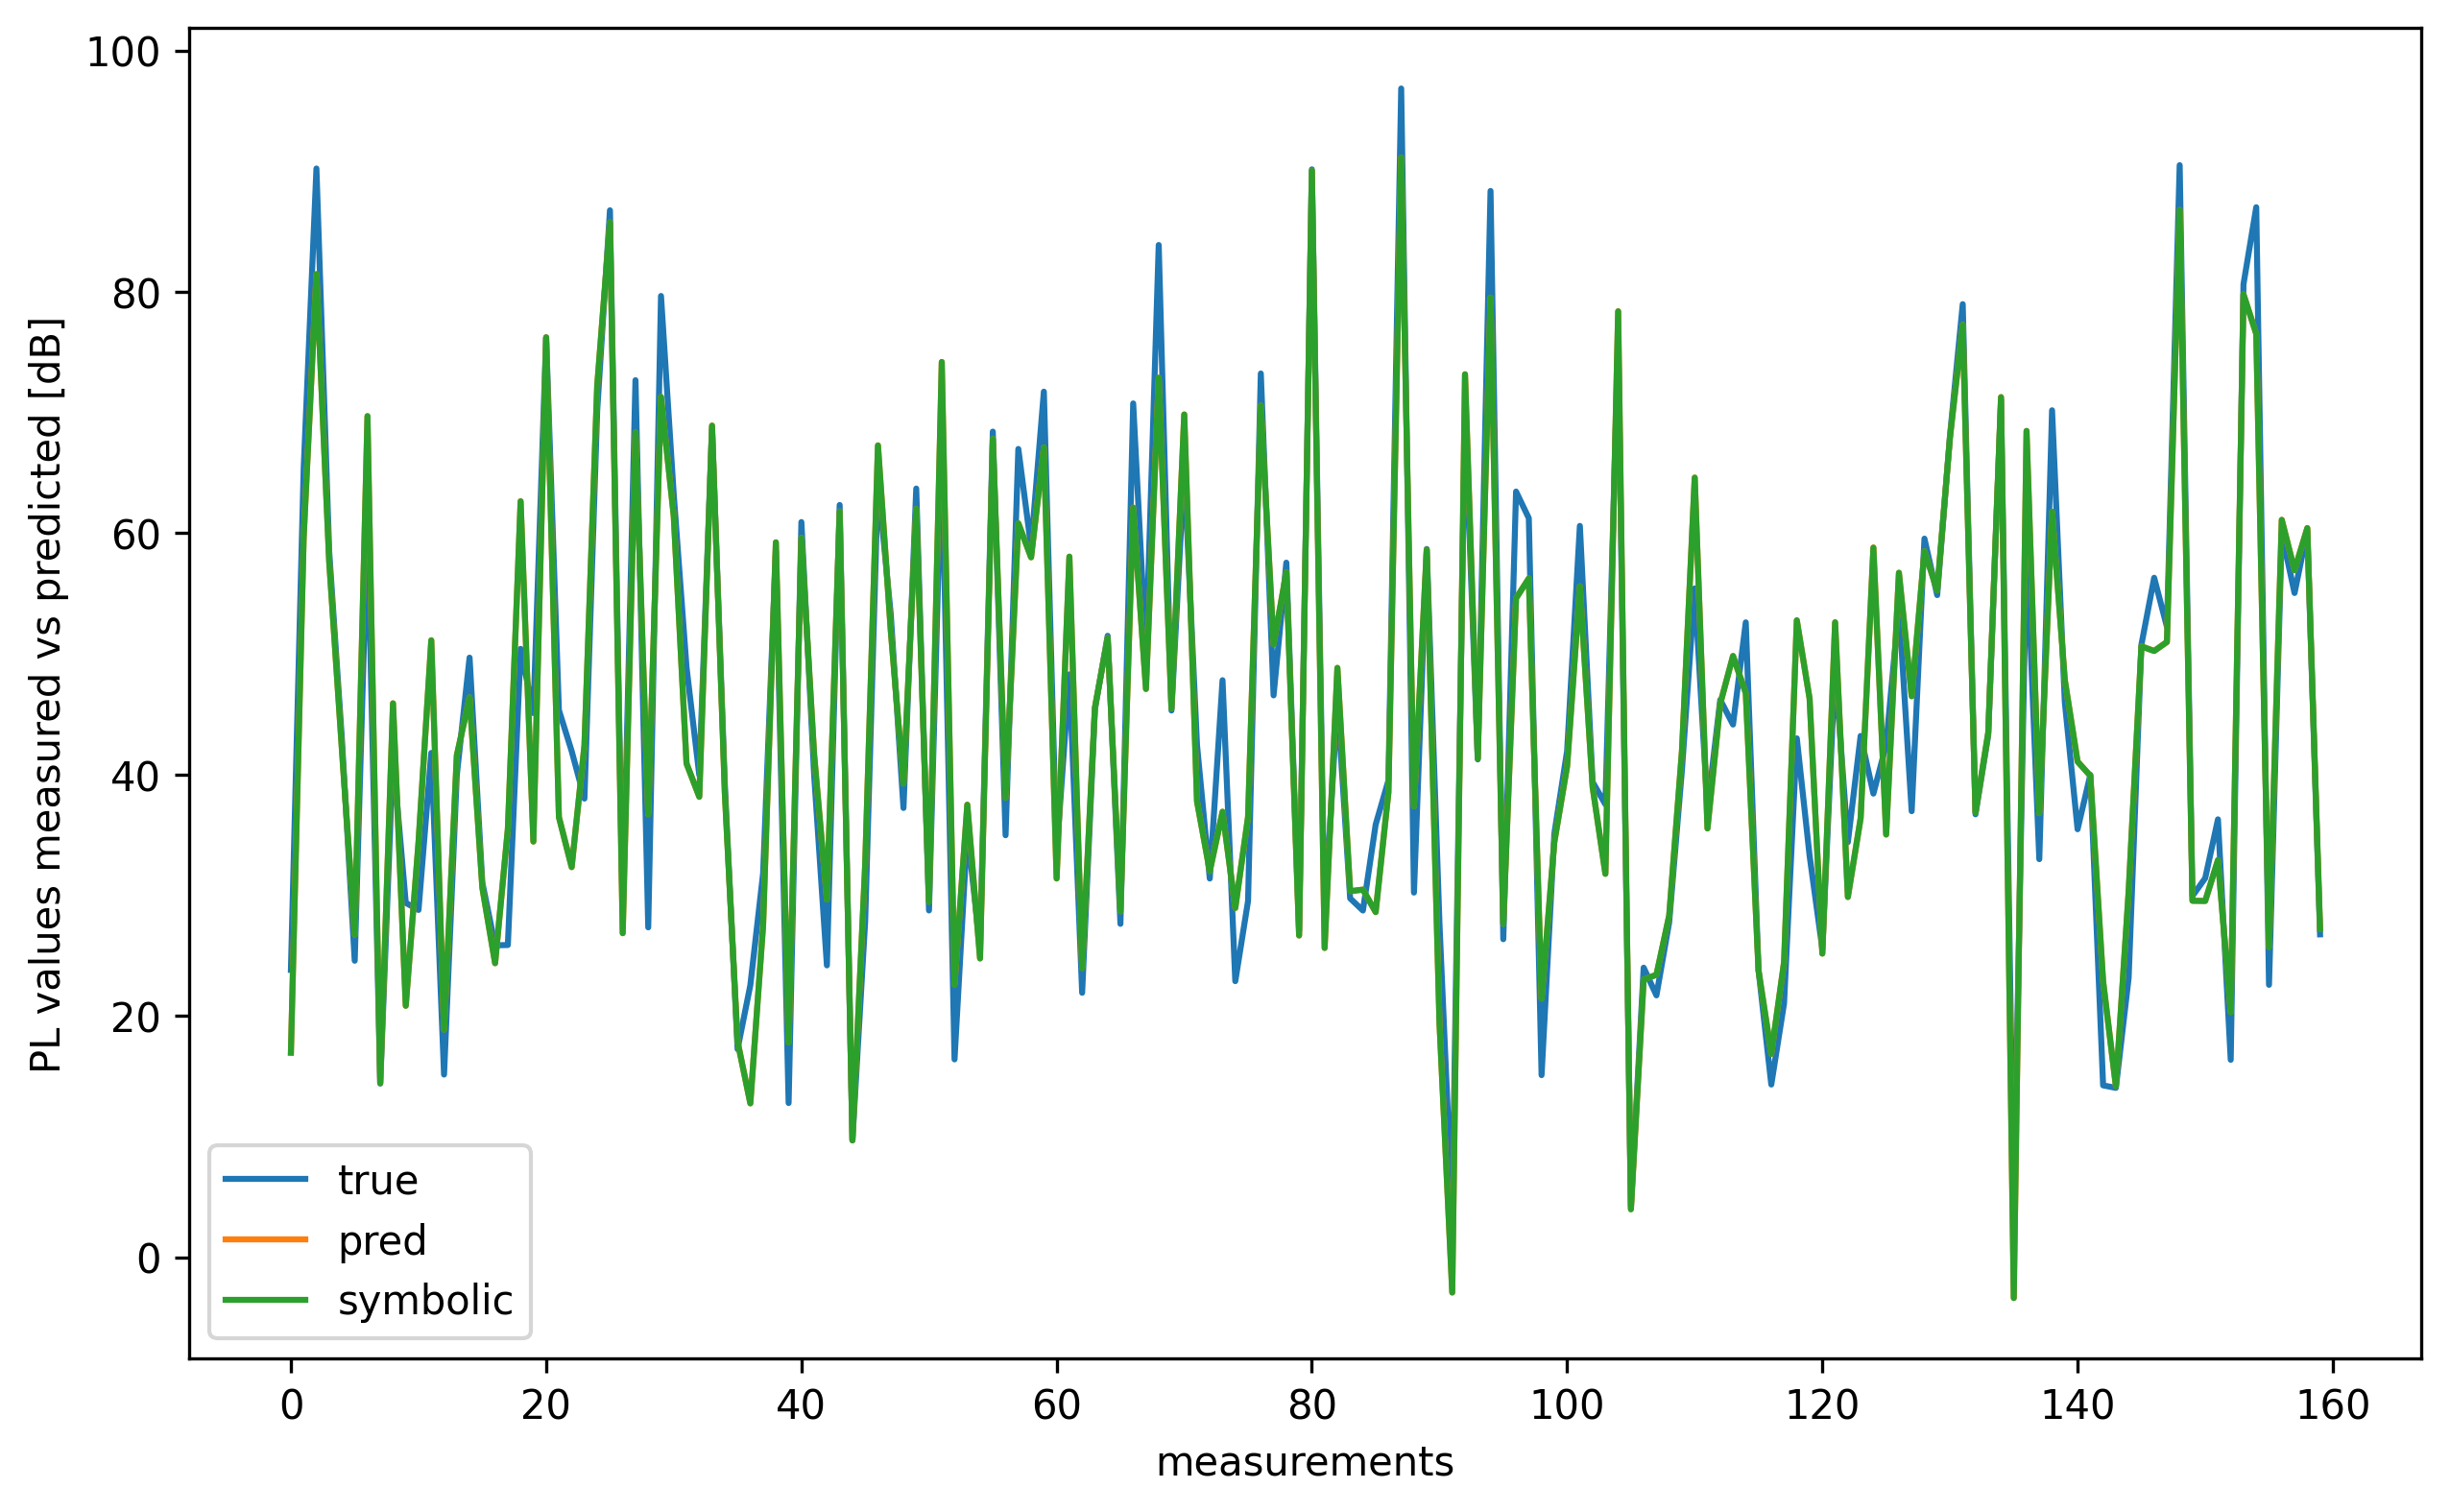

In [55]:


f = lambda x: 9.005 * x[:, 2] + 8.008 * x[:, 5] + 0.016 * (0.028 * x[:, 3] - 1)**2 - 291.519 * torch.log10(8.686 - 3.052 * x[:, 0]) - 53.258 * torch.log10(9.367 - 3.859 * x[:, 4]) + 32.175 * torch.cos(1.116 * x[:, 1] - 1.323) + 313.289 - (0.476 / ((- x[:, 3] - 0.168)**2))
eval_kan(model, f, dataset)

checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.02


| train_loss: 3.92e-01 | test_loss: 5.88e-01 | reg: 9.93e+01 | : 100%|█| 50/50 [00:05<00:00,  8.39it


saving model version 0.1
MAE: 0.4348
MSE: 0.3455
MAPE: 1.6430
R²: 0.9992
RMSE: 0.5878
[np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.002


| train_loss: 4.91e-01 | test_loss: 6.31e-01 | reg: 1.68e+02 | : 100%|█| 50/50 [00:05<00:00,  8.67it


saving model version 0.1
MAE: 0.4711
MSE: 0.3983
MAPE: 1.6395
R²: 0.9990
RMSE: 0.6311
[np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 0.0002


| train_loss: 5.10e-01 | test_loss: 6.74e-01 | reg: 1.77e+02 | : 100%|█| 50/50 [00:05<00:00,  8.63it


saving model version 0.1
MAE: 0.5074
MSE: 0.4539
MAPE: 1.8342
R²: 0.9989
RMSE: 0.6737
[np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 2e-05


| train_loss: 4.64e-01 | test_loss: 6.75e-01 | reg: 1.81e+02 | : 100%|█| 50/50 [00:05<00:00,  8.44it


saving model version 0.1
MAE: 0.4901
MSE: 0.4553
MAPE: 1.9134
R²: 0.9989
RMSE: 0.6747
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 50, 2e-06


| train_loss: 4.82e-01 | test_loss: 6.68e-01 | reg: 1.82e+02 | : 100%|█| 50/50 [00:05<00:00,  8.69it


saving model version 0.1
MAE: 0.4857
MSE: 0.4457
MAPE: 1.8984
R²: 0.9989
RMSE: 0.6676
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.02


| train_loss: 1.75e-01 | test_loss: 2.77e-01 | reg: 4.48e+01 | : 100%|█| 100/100 [00:11<00:00,  8.74


saving model version 0.1
MAE: 0.1976
MSE: 0.0765
MAPE: 0.7149
R²: 0.9998
RMSE: 0.2765
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.002


| train_loss: 2.39e-01 | test_loss: 3.61e-01 | reg: 1.52e+02 | : 100%|█| 100/100 [00:11<00:00,  8.34


saving model version 0.1
MAE: 0.2796
MSE: 0.1300
MAPE: 0.9715
R²: 0.9997
RMSE: 0.3606
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 0.0002


| train_loss: 2.51e-01 | test_loss: 4.16e-01 | reg: 1.76e+02 | : 100%|█| 100/100 [00:12<00:00,  8.07


saving model version 0.1
MAE: 0.3035
MSE: 0.1727
MAPE: 1.1584
R²: 0.9996
RMSE: 0.4156
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-05


| train_loss: 2.24e-01 | test_loss: 3.81e-01 | reg: 1.81e+02 | : 100%|█| 100/100 [00:11<00:00,  8.85


saving model version 0.1
MAE: 0.2751
MSE: 0.1453
MAPE: 1.0480
R²: 0.9996
RMSE: 0.3812
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 100, 2e-06


| train_loss: 2.18e-01 | test_loss: 3.87e-01 | reg: 1.84e+02 | : 100%|█| 100/100 [00:12<00:00,  8.00


saving model version 0.1
MAE: 0.2873
MSE: 0.1495
MAPE: 1.1184
R²: 0.9996
RMSE: 0.3867
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.02


| train_loss: 1.70e-01 | test_loss: 2.34e-01 | reg: 4.07e+01 | : 100%|█| 200/200 [00:20<00:00,  9.70


saving model version 0.1
MAE: 0.1632
MSE: 0.0549
MAPE: 0.4970
R²: 0.9999
RMSE: 0.2343
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.002


| train_loss: 1.35e-01 | test_loss: 2.33e-01 | reg: 1.11e+02 | : 100%|█| 200/200 [00:23<00:00,  8.47


saving model version 0.1
MAE: 0.1629
MSE: 0.0545
MAPE: 0.7040
R²: 0.9999
RMSE: 0.2335
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 0.0002


| train_loss: 1.14e-01 | test_loss: 1.93e-01 | reg: 1.71e+02 | : 100%|█| 200/200 [00:23<00:00,  8.43


saving model version 0.1
MAE: 0.1376
MSE: 0.0371
MAPE: 0.4116
R²: 0.9999
RMSE: 0.1926
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-05


| train_loss: 1.17e-01 | test_loss: 2.14e-01 | reg: 1.78e+02 | : 100%|█| 200/200 [00:23<00:00,  8.64


saving model version 0.1
MAE: 0.1414
MSE: 0.0458
MAPE: 0.5068
R²: 0.9999
RMSE: 0.2141
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 200, 2e-06


| train_loss: 1.22e-01 | test_loss: 1.93e-01 | reg: 1.82e+02 | : 100%|█| 200/200 [00:22<00:00,  8.82


saving model version 0.1
MAE: 0.1362
MSE: 0.0374
MAPE: 0.4411
R²: 0.9999
RMSE: 0.1935
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.02


| train_loss: 1.70e-01 | test_loss: 2.34e-01 | reg: 4.07e+01 | : 100%|█| 300/300 [00:22<00:00, 13.26


saving model version 0.1
MAE: 0.1632
MSE: 0.0549
MAPE: 0.4970
R²: 0.9999
RMSE: 0.2343
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.002


| train_loss: 1.06e-01 | test_loss: 1.90e-01 | reg: 7.78e+01 | : 100%|█| 300/300 [00:33<00:00,  8.84


saving model version 0.1
MAE: 0.1318
MSE: 0.0363
MAPE: 0.5154
R²: 0.9999
RMSE: 0.1905
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 0.0002


| train_loss: 9.38e-02 | test_loss: 1.59e-01 | reg: 1.68e+02 | : 100%|█| 300/300 [00:34<00:00,  8.81


saving model version 0.1
MAE: 0.1109
MSE: 0.0254
MAPE: 0.3469
R²: 0.9999
RMSE: 0.1594
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-05


| train_loss: 9.67e-02 | test_loss: 1.84e-01 | reg: 1.76e+02 | : 100%|█| 300/300 [00:33<00:00,  8.92


saving model version 0.1
MAE: 0.1197
MSE: 0.0340
MAPE: 0.4144
R²: 0.9999
RMSE: 0.1843
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 5, steps 300, 2e-06


| train_loss: 9.95e-02 | test_loss: 1.67e-01 | reg: 1.83e+02 | : 100%|█| 300/300 [00:33<00:00,  8.87


saving model version 0.1
MAE: 0.1118
MSE: 0.0278
MAPE: 0.3537
R²: 0.9999
RMSE: 0.1669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.02


| train_loss: 3.82e-01 | test_loss: 6.69e-01 | reg: 1.47e+02 | : 100%|█| 50/50 [00:05<00:00,  8.48it


saving model version 0.1
MAE: 0.4802
MSE: 0.4478
MAPE: 1.6534
R²: 0.9989
RMSE: 0.6692
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.002


| train_loss: 3.55e-01 | test_loss: 6.15e-01 | reg: 1.82e+02 | : 100%|█| 50/50 [00:05<00:00,  8.55it


saving model version 0.1
MAE: 0.4157
MSE: 0.3779
MAPE: 1.6664
R²: 0.9991
RMSE: 0.6147
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 0.0002


| train_loss: 4.17e-01 | test_loss: 6.75e-01 | reg: 1.82e+02 | : 100%|█| 50/50 [00:05<00:00,  8.54it


saving model version 0.1
MAE: 0.4840
MSE: 0.4557
MAPE: 1.7333
R²: 0.9989
RMSE: 0.6750
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 2e-05


| train_loss: 3.64e-01 | test_loss: 5.56e-01 | reg: 1.76e+02 | : 100%|█| 50/50 [00:05<00:00,  8.68it


saving model version 0.1
MAE: 0.4198
MSE: 0.3094
MAPE: 1.6357
R²: 0.9992
RMSE: 0.5562
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 50, 2e-06


| train_loss: 4.18e-01 | test_loss: 7.06e-01 | reg: 1.86e+02 | : 100%|█| 50/50 [00:05<00:00,  8.71it


saving model version 0.1
MAE: 0.5058
MSE: 0.4986
MAPE: 2.0239
R²: 0.9988
RMSE: 0.7061
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.02


| train_loss: 3.25e-01 | test_loss: 5.35e-01 | reg: 7.73e+01 | : 100%|█| 100/100 [00:11<00:00,  8.86


saving model version 0.1
MAE: 0.3594
MSE: 0.2862
MAPE: 1.3338
R²: 0.9993
RMSE: 0.5350
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.002


| train_loss: 1.89e-01 | test_loss: 3.23e-01 | reg: 1.71e+02 | : 100%|█| 100/100 [00:11<00:00,  8.74


saving model version 0.1
MAE: 0.2434
MSE: 0.1043
MAPE: 0.7573
R²: 0.9997
RMSE: 0.3229
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 0.0002


| train_loss: 1.63e-01 | test_loss: 2.60e-01 | reg: 1.80e+02 | : 100%|█| 100/100 [00:11<00:00,  8.68


saving model version 0.1
MAE: 0.1905
MSE: 0.0674
MAPE: 0.6262
R²: 0.9998
RMSE: 0.2597
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-05


| train_loss: 1.57e-01 | test_loss: 2.88e-01 | reg: 1.75e+02 | : 100%|█| 100/100 [00:11<00:00,  8.39


saving model version 0.1
MAE: 0.2001
MSE: 0.0829
MAPE: 0.7813
R²: 0.9998
RMSE: 0.2879
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 100, 2e-06


| train_loss: 1.85e-01 | test_loss: 3.31e-01 | reg: 1.87e+02 | : 100%|█| 100/100 [00:12<00:00,  8.08


saving model version 0.1
MAE: 0.2400
MSE: 0.1092
MAPE: 0.8753
R²: 0.9997
RMSE: 0.3305
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.02


| train_loss: 1.60e-01 | test_loss: 2.24e-01 | reg: 4.10e+01 | : 100%|█| 200/200 [00:24<00:00,  8.20


saving model version 0.1
MAE: 0.1582
MSE: 0.0502
MAPE: 0.6265
R²: 0.9999
RMSE: 0.2241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.002


| train_loss: 1.01e-01 | test_loss: 1.46e-01 | reg: 1.48e+02 | : 100%|█| 200/200 [00:23<00:00,  8.42


saving model version 0.1
MAE: 0.1085
MSE: 0.0213
MAPE: 0.3160
R²: 0.9999
RMSE: 0.1459
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 0.0002


| train_loss: 6.84e-02 | test_loss: 1.17e-01 | reg: 1.78e+02 | : 100%|█| 200/200 [00:22<00:00,  8.82


saving model version 0.1
MAE: 0.0859
MSE: 0.0137
MAPE: 0.3031
R²: 1.0000
RMSE: 0.1169
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-05


| train_loss: 7.00e-02 | test_loss: 1.29e-01 | reg: 1.72e+02 | : 100%|█| 200/200 [00:24<00:00,  8.16


saving model version 0.1
MAE: 0.0921
MSE: 0.0167
MAPE: 0.3255
R²: 1.0000
RMSE: 0.1290
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 200, 2e-06


| train_loss: 8.11e-02 | test_loss: 1.48e-01 | reg: 1.87e+02 | : 100%|█| 200/200 [00:23<00:00,  8.53


saving model version 0.1
MAE: 0.1058
MSE: 0.0220
MAPE: 0.3835
R²: 0.9999
RMSE: 0.1485
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.02


| train_loss: 1.60e-01 | test_loss: 2.24e-01 | reg: 4.10e+01 | : 100%|█| 300/300 [00:26<00:00, 11.43


saving model version 0.1
MAE: 0.1582
MSE: 0.0502
MAPE: 0.6263
R²: 0.9999
RMSE: 0.2241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.002


| train_loss: 1.05e-01 | test_loss: 2.03e-01 | reg: 1.10e+02 | : 100%|█| 300/300 [00:35<00:00,  8.34


saving model version 0.1
MAE: 0.1256
MSE: 0.0413
MAPE: 0.4708
R²: 0.9999
RMSE: 0.2031
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 0.0002


| train_loss: 5.04e-02 | test_loss: 7.92e-02 | reg: 1.76e+02 | : 100%|█| 300/300 [00:34<00:00,  8.73


saving model version 0.1
MAE: 0.0571
MSE: 0.0063
MAPE: 0.2273
R²: 1.0000
RMSE: 0.0792
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-05


| train_loss: 5.21e-02 | test_loss: 8.81e-02 | reg: 1.71e+02 | : 100%|█| 300/300 [00:35<00:00,  8.46


saving model version 0.1
MAE: 0.0617
MSE: 0.0078
MAPE: 0.2377
R²: 1.0000
RMSE: 0.0881
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 8, steps 300, 2e-06


| train_loss: 6.15e-02 | test_loss: 1.13e-01 | reg: 1.87e+02 | : 100%|█| 300/300 [00:35<00:00,  8.57


saving model version 0.1
MAE: 0.0823
MSE: 0.0129
MAPE: 0.3040
R²: 1.0000
RMSE: 0.1134
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.02


| train_loss: 1.31e-01 | test_loss: 2.07e-01 | reg: 4.56e+01 | : 100%|█| 50/50 [00:05<00:00,  8.48it


saving model version 0.1
MAE: 0.1480
MSE: 0.0428
MAPE: 0.6544
R²: 0.9999
RMSE: 0.2069
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.002


| train_loss: 7.29e-02 | test_loss: 1.65e-01 | reg: 5.73e+01 | : 100%|█| 50/50 [00:05<00:00,  8.55it


saving model version 0.1
MAE: 0.0992
MSE: 0.0271
MAPE: 0.4366
R²: 0.9999
RMSE: 0.1645
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 0.0002


| train_loss: 7.25e-02 | test_loss: 2.07e-01 | reg: 6.34e+01 | : 100%|█| 50/50 [00:06<00:00,  8.18it


saving model version 0.1
MAE: 0.1407
MSE: 0.0429
MAPE: 0.5096
R²: 0.9999
RMSE: 0.2071
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10, steps 50, 2e-05


| train_loss: 1.01e-01 | test_loss: 2.73e-01 | reg: 6.97e+01 | : 100%|█| 50/50 [00:06<00:00,  8.14it


saving model version 0.1
MAE: 0.1785
MSE: 0.0746
MAPE: 0.5617
R²: 0.9998
RMSE: 0.2731
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05)]
checkpoint directory created: ./model
saving model version 0.0
Grid size: 10,

| train_loss: 9.00e-02 | test_loss: 1.94e-01 | reg: 6.64e+01 | : 100%|█| 50/50 [00:05<00:00,  8.59it


saving model version 0.1
MAE: 0.1307
MSE: 0.0378
MAPE: 0.4929
R²: 0.9999
RMSE: 0.1944
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06)]
checkpoint directory created: ./model
saving model version

| train_loss: 1.16e-01 | test_loss: 2.04e-01 | reg: 4.30e+01 | : 100%|█| 100/100 [00:11<00:00,  8.90


saving model version 0.1
MAE: 0.1244
MSE: 0.0415
MAPE: 0.5356
R²: 0.9999
RMSE: 0.2038
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02)]
checkpoint directory created: ./model
sa

| train_loss: 4.97e-02 | test_loss: 7.98e-02 | reg: 4.28e+01 | : 100%|█| 100/100 [00:11<00:00,  8.44


saving model version 0.1
MAE: 0.0552
MSE: 0.0064
MAPE: 0.2760
R²: 1.0000
RMSE: 0.0798
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002)]
checkpoint directory 

| train_loss: 3.49e-02 | test_loss: 1.07e-01 | reg: 5.91e+01 | : 100%|█| 100/100 [00:11<00:00,  8.93


saving model version 0.1
MAE: 0.0750
MSE: 0.0114
MAPE: 0.3019
R²: 1.0000
RMSE: 0.1069
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002)]
c

| train_loss: 3.58e-02 | test_loss: 1.18e-01 | reg: 6.80e+01 | : 100%|█| 100/100 [00:11<00:00,  8.67


saving model version 0.1
MAE: 0.0820
MSE: 0.0138
MAPE: 0.3697
R²: 1.0000
RMSE: 0.1177
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.23e-02 | test_loss: 1.05e-01 | reg: 6.50e+01 | : 100%|█| 100/100 [00:12<00:00,  8.23


saving model version 0.1
MAE: 0.0660
MSE: 0.0111
MAPE: 0.2844
R²: 1.0000
RMSE: 0.1051
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.46e-01 | test_loss: 2.45e-01 | reg: 4.08e+01 | : 100%|█| 200/200 [00:19<00:00, 10.32


saving model version 0.1
MAE: 0.1901
MSE: 0.0601
MAPE: 0.7228
R²: 0.9999
RMSE: 0.2451
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.75e-02 | test_loss: 6.62e-02 | reg: 3.86e+01 | : 100%|█| 200/200 [00:20<00:00,  9.83


saving model version 0.1
MAE: 0.0438
MSE: 0.0044
MAPE: 0.2413
R²: 1.0000
RMSE: 0.0662
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.48e-02 | test_loss: 7.56e-02 | reg: 5.25e+01 | : 100%|█| 200/200 [00:23<00:00,  8.65


saving model version 0.1
MAE: 0.0479
MSE: 0.0057
MAPE: 0.1941
R²: 1.0000
RMSE: 0.0756
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.82e-02 | test_loss: 7.76e-02 | reg: 6.51e+01 | : 100%|█| 200/200 [00:25<00:00,  7.88


saving model version 0.1
MAE: 0.0448
MSE: 0.0060
MAPE: 0.2263
R²: 1.0000
RMSE: 0.0776
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.71e-02 | test_loss: 6.23e-02 | reg: 6.50e+01 | : 100%|█| 200/200 [00:23<00:00,  8.53


saving model version 0.1
MAE: 0.0371
MSE: 0.0039
MAPE: 0.1764
R²: 1.0000
RMSE: 0.0623
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.46e-01 | test_loss: 2.45e-01 | reg: 4.08e+01 | : 100%|█| 300/300 [00:26<00:00, 11.43


saving model version 0.1
MAE: 0.1901
MSE: 0.0601
MAPE: 0.7228
R²: 0.9999
RMSE: 0.2451
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.75e-02 | test_loss: 6.62e-02 | reg: 3.86e+01 | : 100%|█| 300/300 [00:25<00:00, 11.87


saving model version 0.1
MAE: 0.0438
MSE: 0.0044
MAPE: 0.2413
R²: 1.0000
RMSE: 0.0662
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.10e-02 | test_loss: 5.86e-02 | reg: 4.85e+01 | : 100%|█| 300/300 [00:35<00:00,  8.40


saving model version 0.1
MAE: 0.0371
MSE: 0.0034
MAPE: 0.1852
R²: 1.0000
RMSE: 0.0586
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.46e-02 | test_loss: 6.16e-02 | reg: 6.25e+01 | : 100%|█| 300/300 [00:35<00:00,  8.35


saving model version 0.1
MAE: 0.0365
MSE: 0.0038
MAPE: 0.1693
R²: 1.0000
RMSE: 0.0616
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.21e-02 | test_loss: 5.79e-02 | reg: 6.53e+01 | : 100%|█| 300/300 [00:35<00:00,  8.46


saving model version 0.1
MAE: 0.0318
MSE: 0.0034
MAPE: 0.1614
R²: 1.0000
RMSE: 0.0579
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.52e-01 | test_loss: 3.10e-01 | reg: 4.48e+01 | : 100%|█| 50/50 [00:05<00:00,  8.42it


saving model version 0.1
MAE: 0.1943
MSE: 0.0963
MAPE: 0.7319
R²: 0.9998
RMSE: 0.3103
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.20e-01 | test_loss: 3.32e-01 | reg: 8.06e+01 | : 100%|█| 50/50 [00:05<00:00,  8.66it


saving model version 0.1
MAE: 0.2490
MSE: 0.1104
MAPE: 0.8481
R²: 0.9997
RMSE: 0.3323
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.25e-01 | test_loss: 3.58e-01 | reg: 8.46e+01 | : 100%|█| 50/50 [00:05<00:00,  8.60it


saving model version 0.1
MAE: 0.2740
MSE: 0.1280
MAPE: 1.1159
R²: 0.9997
RMSE: 0.3578
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.76e-01 | test_loss: 7.47e-01 | reg: 8.92e+01 | : 100%|█| 50/50 [00:05<00:00,  8.98it


saving model version 0.1
MAE: 0.5723
MSE: 0.5579
MAPE: 2.1230
R²: 0.9986
RMSE: 0.7469
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.21e-01 | test_loss: 4.07e-01 | reg: 9.16e+01 | : 100%|█| 50/50 [00:05<00:00,  9.06it


saving model version 0.1
MAE: 0.2982
MSE: 0.1655
MAPE: 1.3115
R²: 0.9996
RMSE: 0.4068
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.48e-01 | test_loss: 3.12e-01 | reg: 4.43e+01 | : 100%|█| 100/100 [00:07<00:00, 12.56


saving model version 0.1
MAE: 0.1934
MSE: 0.0972
MAPE: 0.7390
R²: 0.9998
RMSE: 0.3117
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 5.93e-02 | test_loss: 1.18e-01 | reg: 5.18e+01 | : 100%|█| 100/100 [00:11<00:00,  8.90


saving model version 0.1
MAE: 0.0821
MSE: 0.0139
MAPE: 0.3756
R²: 1.0000
RMSE: 0.1181
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.05e-02 | test_loss: 1.84e-01 | reg: 8.06e+01 | : 100%|█| 100/100 [00:11<00:00,  9.01


saving model version 0.1
MAE: 0.1325
MSE: 0.0338
MAPE: 0.5586
R²: 0.9999
RMSE: 0.1839
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 5.57e-02 | test_loss: 3.93e-01 | reg: 8.89e+01 | : 100%|█| 100/100 [00:11<00:00,  8.74


saving model version 0.1
MAE: 0.2992
MSE: 0.1548
MAPE: 1.0461
R²: 0.9996
RMSE: 0.3934
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.06e-02 | test_loss: 2.09e-01 | reg: 9.12e+01 | : 100%|█| 100/100 [00:11<00:00,  8.82


saving model version 0.1
MAE: 0.1501
MSE: 0.0436
MAPE: 0.5944
R²: 0.9999
RMSE: 0.2088
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.48e-01 | test_loss: 3.12e-01 | reg: 4.43e+01 | : 100%|█| 200/200 [00:11<00:00, 17.44


saving model version 0.1
MAE: 0.1934
MSE: 0.0972
MAPE: 0.7390
R²: 0.9998
RMSE: 0.3117
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.59e-02 | test_loss: 8.82e-02 | reg: 4.10e+01 | : 100%|█| 200/200 [00:22<00:00,  9.07


saving model version 0.1
MAE: 0.0606
MSE: 0.0078
MAPE: 0.2689
R²: 1.0000
RMSE: 0.0882
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.77e-02 | test_loss: 8.78e-02 | reg: 6.81e+01 | : 100%|█| 200/200 [00:21<00:00,  9.24


saving model version 0.1
MAE: 0.0607
MSE: 0.0077
MAPE: 0.1958
R²: 1.0000
RMSE: 0.0878
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.48e-02 | test_loss: 2.90e-01 | reg: 8.92e+01 | : 100%|█| 200/200 [00:21<00:00,  9.32


saving model version 0.1
MAE: 0.2196
MSE: 0.0841
MAPE: 0.7560
R²: 0.9998
RMSE: 0.2901
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.13e-02 | test_loss: 1.45e-01 | reg: 9.03e+01 | : 100%|█| 200/200 [00:21<00:00,  9.35


saving model version 0.1
MAE: 0.1056
MSE: 0.0211
MAPE: 0.4912
R²: 0.9999
RMSE: 0.1453
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.48e-01 | test_loss: 3.12e-01 | reg: 4.43e+01 | : 100%|█| 300/300 [00:14<00:00, 20.07


saving model version 0.1
MAE: 0.1934
MSE: 0.0972
MAPE: 0.7390
R²: 0.9998
RMSE: 0.3117
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.59e-02 | test_loss: 8.81e-02 | reg: 4.10e+01 | : 100%|█| 300/300 [00:25<00:00, 11.85


saving model version 0.1
MAE: 0.0606
MSE: 0.0078
MAPE: 0.2689
R²: 1.0000
RMSE: 0.0881
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.47e-02 | test_loss: 6.69e-02 | reg: 5.86e+01 | : 100%|█| 300/300 [00:31<00:00,  9.42


saving model version 0.1
MAE: 0.0454
MSE: 0.0045
MAPE: 0.1758
R²: 1.0000
RMSE: 0.0669
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.83e-02 | test_loss: 2.75e-01 | reg: 8.87e+01 | : 100%|█| 300/300 [00:34<00:00,  8.78


saving model version 0.1
MAE: 0.2057
MSE: 0.0757
MAPE: 0.7716
R²: 0.9998
RMSE: 0.2751
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.62e-02 | test_loss: 1.39e-01 | reg: 9.02e+01 | : 100%|█| 300/300 [00:33<00:00,  8.85


saving model version 0.1
MAE: 0.0998
MSE: 0.0192
MAPE: 0.4534
R²: 1.0000
RMSE: 0.1385
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.58e-01 | test_loss: 3.54e-01 | reg: 3.96e+01 | : 100%|█| 50/50 [00:05<00:00,  8.59it


saving model version 0.1
MAE: 0.2570
MSE: 0.1254
MAPE: 0.9363
R²: 0.9997
RMSE: 0.3541
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.38e-01 | test_loss: 5.24e-01 | reg: 7.32e+01 | : 100%|█| 50/50 [00:06<00:00,  7.91it


saving model version 0.1
MAE: 0.3548
MSE: 0.2751
MAPE: 1.3236
R²: 0.9993
RMSE: 0.5245
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.35e-01 | test_loss: 6.16e-01 | reg: 6.98e+01 | : 100%|█| 50/50 [00:05<00:00,  8.62it


saving model version 0.1
MAE: 0.4247
MSE: 0.3794
MAPE: 1.4566
R²: 0.9991
RMSE: 0.6160
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.78e-01 | test_loss: 1.30e+00 | reg: 7.01e+01 | : 100%|█| 50/50 [00:06<00:00,  8.19it


saving model version 0.1
MAE: 0.9710
MSE: 1.6901
MAPE: 3.5575
R²: 0.9959
RMSE: 1.3000
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.20e-01 | test_loss: 5.86e-01 | reg: 6.96e+01 | : 100%|█| 50/50 [00:06<00:00,  8.26it


saving model version 0.1
MAE: 0.4104
MSE: 0.3439
MAPE: 1.6777
R²: 0.9992
RMSE: 0.5864
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.04e-01 | test_loss: 2.24e-01 | reg: 3.75e+01 | : 100%|█| 100/100 [00:11<00:00,  8.67


saving model version 0.1
MAE: 0.1458
MSE: 0.0502
MAPE: 0.5610
R²: 0.9999
RMSE: 0.2241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 7.01e-02 | test_loss: 4.90e-01 | reg: 6.62e+01 | : 100%|█| 100/100 [00:12<00:00,  8.31


saving model version 0.1
MAE: 0.3607
MSE: 0.2400
MAPE: 1.4214
R²: 0.9994
RMSE: 0.4899
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.40e-02 | test_loss: 6.38e-01 | reg: 6.98e+01 | : 100%|█| 100/100 [00:11<00:00,  8.56


saving model version 0.1
MAE: 0.4624
MSE: 0.4065
MAPE: 1.8247
R²: 0.9990
RMSE: 0.6375
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.60e-02 | test_loss: 1.39e+00 | reg: 7.09e+01 | : 100%|█| 100/100 [00:11<00:00,  8.46


saving model version 0.1
MAE: 1.0883
MSE: 1.9450
MAPE: 3.8488
R²: 0.9953
RMSE: 1.3946
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.31e-02 | test_loss: 5.64e-01 | reg: 7.02e+01 | : 100%|█| 100/100 [00:11<00:00,  8.35


saving model version 0.1
MAE: 0.4262
MSE: 0.3182
MAPE: 1.8057
R²: 0.9992
RMSE: 0.5641
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.04e-01 | test_loss: 2.24e-01 | reg: 3.75e+01 | : 100%|█| 200/200 [00:16<00:00, 12.07


saving model version 0.1
MAE: 0.1458
MSE: 0.0502
MAPE: 0.5610
R²: 0.9999
RMSE: 0.2241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.19e-02 | test_loss: 4.15e-01 | reg: 5.74e+01 | : 100%|█| 200/200 [00:23<00:00,  8.40


saving model version 0.1
MAE: 0.3067
MSE: 0.1725
MAPE: 1.0923
R²: 0.9996
RMSE: 0.4153
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 9.09e-03 | test_loss: 6.73e-01 | reg: 6.87e+01 | : 100%|█| 200/200 [00:23<00:00,  8.49


saving model version 0.1
MAE: 0.5102
MSE: 0.4526
MAPE: 2.0228
R²: 0.9989
RMSE: 0.6727
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 5.01e-03 | test_loss: 1.38e+00 | reg: 7.10e+01 | : 100%|█| 200/200 [00:22<00:00,  8.77


saving model version 0.1
MAE: 1.0606
MSE: 1.9084
MAPE: 3.8044
R²: 0.9954
RMSE: 1.3814
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 8.48e-03 | test_loss: 6.02e-01 | reg: 7.05e+01 | : 100%|█| 200/200 [00:22<00:00,  8.70


saving model version 0.1
MAE: 0.4597
MSE: 0.3622
MAPE: 1.9796
R²: 0.9991
RMSE: 0.6018
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.04e-01 | test_loss: 2.24e-01 | reg: 3.75e+01 | : 100%|█| 300/300 [00:21<00:00, 13.85


saving model version 0.1
MAE: 0.1458
MSE: 0.0502
MAPE: 0.5610
R²: 0.9999
RMSE: 0.2241
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 5.54e-02 | test_loss: 1.40e-01 | reg: 4.47e+01 | : 100%|█| 300/300 [00:34<00:00,  8.58


saving model version 0.1
MAE: 0.0902
MSE: 0.0197
MAPE: 0.4034
R²: 1.0000
RMSE: 0.1405
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 8.23e-03 | test_loss: 7.45e-01 | reg: 6.71e+01 | : 100%|█| 300/300 [00:34<00:00,  8.74


saving model version 0.1
MAE: 0.5761
MSE: 0.5556
MAPE: 2.3197
R²: 0.9986
RMSE: 0.7454
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 9.78e-04 | test_loss: 1.37e+00 | reg: 7.08e+01 | : 100%|█| 300/300 [00:33<00:00,  8.83


saving model version 0.1
MAE: 1.0369
MSE: 1.8703
MAPE: 3.7646
R²: 0.9954
RMSE: 1.3676
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.60e-03 | test_loss: 6.00e-01 | reg: 7.05e+01 | : 100%|█| 300/300 [00:33<00:00,  8.91


saving model version 0.1
MAE: 0.4530
MSE: 0.3603
MAPE: 1.9578
R²: 0.9991
RMSE: 0.6003
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.01e-01 | test_loss: 3.51e+00 | reg: 1.05e+02 | : 100%|█| 50/50 [00:06<00:00,  8.10it


saving model version 0.1
MAE: 2.6806
MSE: 12.2874
MAPE: 9.0278
R²: 0.9701
RMSE: 3.5053
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.33e-01 | test_loss: 4.10e+00 | reg: 1.38e+02 | : 100%|█| 50/50 [00:06<00:00,  8.10it


saving model version 0.1
MAE: 2.9794
MSE: 16.8473
MAPE: 9.4737
R²: 0.9590
RMSE: 4.1045
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.15e-01 | test_loss: 3.91e+00 | reg: 1.43e+02 | : 100%|█| 50/50 [00:06<00:00,  8.11it


saving model version 0.1
MAE: 2.8794
MSE: 15.2652
MAPE: 8.9543
R²: 0.9629
RMSE: 3.9071
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.53e-01 | test_loss: 4.18e+00 | reg: 1.42e+02 | : 100%|█| 50/50 [00:06<00:00,  8.08it


saving model version 0.1
MAE: 3.0799
MSE: 17.5050
MAPE: 9.2721
R²: 0.9574
RMSE: 4.1839
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.28e-01 | test_loss: 3.71e+00 | reg: 1.44e+02 | : 100%|█| 50/50 [00:06<00:00,  8.08it


saving model version 0.1
MAE: 2.8093
MSE: 13.7414
MAPE: 8.0407
R²: 0.9666
RMSE: 3.7069
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.19e-01 | test_loss: 4.11e+00 | reg: 7.79e+01 | : 100%|█| 100/100 [00:12<00:00,  8.33


saving model version 0.1
MAE: 3.3014
MSE: 16.9035
MAPE: 9.6966
R²: 0.9589
RMSE: 4.1114
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 4.64e-02 | test_loss: 4.34e+00 | reg: 1.28e+02 | : 100%|█| 100/100 [00:12<00:00,  8.29


saving model version 0.1
MAE: 3.1794
MSE: 18.8232
MAPE: 9.3315
R²: 0.9542
RMSE: 4.3386
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.97e-03 | test_loss: 4.16e+00 | reg: 1.43e+02 | : 100%|█| 100/100 [00:12<00:00,  8.22


saving model version 0.1
MAE: 3.1889
MSE: 17.3272
MAPE: 9.7091
R²: 0.9578
RMSE: 4.1626
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.30e-03 | test_loss: 4.47e+00 | reg: 1.42e+02 | : 100%|█| 100/100 [00:12<00:00,  8.24


saving model version 0.1
MAE: 3.2781
MSE: 20.0101
MAPE: 9.6847
R²: 0.9513
RMSE: 4.4733
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.23e-03 | test_loss: 4.01e+00 | reg: 1.44e+02 | : 100%|█| 100/100 [00:12<00:00,  8.23


saving model version 0.1
MAE: 3.0648
MSE: 16.0996
MAPE: 8.8909
R²: 0.9608
RMSE: 4.0124
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.40e-02 | test_loss: 3.61e+00 | reg: 6.57e+01 | : 100%|█| 200/200 [00:23<00:00,  8.56


saving model version 0.1
MAE: 2.7839
MSE: 13.0376
MAPE: 8.8830
R²: 0.9683
RMSE: 3.6108
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.21e-02 | test_loss: 4.56e+00 | reg: 1.07e+02 | : 100%|█| 200/200 [00:24<00:00,  8.18


saving model version 0.1
MAE: 3.6648
MSE: 20.7575
MAPE: 10.7029
R²: 0.9495
RMSE: 4.5560
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 8.34e-03 | test_loss: 4.33e+00 | reg: 1.36e+02 | : 100%|█| 200/200 [00:23<00:00,  8.50


saving model version 0.1
MAE: 3.3530
MSE: 18.7101
MAPE: 10.3070
R²: 0.9545
RMSE: 4.3255
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.81e-04 | test_loss: 4.47e+00 | reg: 1.42e+02 | : 100%|█| 200/200 [00:18<00:00, 11.01


saving model version 0.1
MAE: 3.2832
MSE: 20.0149
MAPE: 9.7015
R²: 0.9513
RMSE: 4.4738
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 4.90e-04 | test_loss: 4.01e+00 | reg: 1.44e+02 | : 100%|█| 200/200 [00:16<00:00, 11.81


saving model version 0.1
MAE: 3.0655
MSE: 16.1115
MAPE: 8.8984
R²: 0.9608
RMSE: 4.0139
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 6.82e-02 | test_loss: 3.90e+00 | reg: 6.00e+01 | : 100%|█| 300/300 [00:32<00:00,  9.22


saving model version 0.1
MAE: 3.0289
MSE: 15.1893
MAPE: 9.5199
R²: 0.9630
RMSE: 3.8973
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.25e-02 | test_loss: 4.86e+00 | reg: 9.72e+01 | : 100%|█| 300/300 [00:34<00:00,  8.65


saving model version 0.1
MAE: 3.7873
MSE: 23.5863
MAPE: 11.0996
R²: 0.9426
RMSE: 4.8566
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 6.37e-03 | test_loss: 4.61e+00 | reg: 1.28e+02 | : 100%|█| 300/300 [00:35<00:00,  8.52


saving model version 0.1
MAE: 3.6276
MSE: 21.2243
MAPE: 10.9178
R²: 0.9484
RMSE: 4.6070
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.81e-04 | test_loss: 4.47e+00 | reg: 1.42e+02 | : 100%|█| 300/300 [00:21<00:00, 13.79


saving model version 0.1
MAE: 3.2832
MSE: 20.0149
MAPE: 9.7015
R²: 0.9513
RMSE: 4.4738
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 4.90e-04 | test_loss: 4.01e+00 | reg: 1.44e+02 | : 100%|█| 300/300 [00:20<00:00, 14.84


saving model version 0.1
MAE: 3.0655
MSE: 16.1115
MAPE: 8.8984
R²: 0.9608
RMSE: 4.0139
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.85e-01 | test_loss: 2.77e+00 | reg: 1.11e+02 | : 100%|█| 50/50 [00:06<00:00,  7.92it


saving model version 0.1
MAE: 2.0814
MSE: 7.6844
MAPE: 6.2983
R²: 0.9813
RMSE: 2.7721
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 2.71e-01 | test_loss: 2.66e+00 | reg: 2.21e+02 | : 100%|█| 50/50 [00:06<00:00,  7.53it


saving model version 0.1
MAE: 1.8288
MSE: 7.0559
MAPE: 6.6019
R²: 0.9828
RMSE: 2.6563
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.66e-01 | test_loss: 4.03e+00 | reg: 2.63e+02 | : 100%|█| 50/50 [00:06<00:00,  7.70it


saving model version 0.1
MAE: 3.0550
MSE: 16.2339
MAPE: 11.0264
R²: 0.9605
RMSE: 4.0291
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 5.37e-01 | test_loss: 3.91e+00 | reg: 2.49e+02 | : 100%|█| 50/50 [00:06<00:00,  7.78it


saving model version 0.1
MAE: 3.0374
MSE: 15.2637
MAPE: 9.7359
R²: 0.9629
RMSE: 3.9069
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.05e-01 | test_loss: 3.66e+00 | reg: 2.09e+02 | : 100%|█| 50/50 [00:06<00:00,  7.71it


saving model version 0.1
MAE: 2.6241
MSE: 13.4299
MAPE: 9.4505
R²: 0.9673
RMSE: 3.6647
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 9.66e-02 | test_loss: 3.32e+00 | reg: 8.61e+01 | : 100%|█| 100/100 [00:12<00:00,  8.18


saving model version 0.1
MAE: 2.5930
MSE: 10.9990
MAPE: 8.1569
R²: 0.9732
RMSE: 3.3165
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.97e-02 | test_loss: 2.71e+00 | reg: 2.14e+02 | : 100%|█| 100/100 [00:12<00:00,  7.76


saving model version 0.1
MAE: 1.9131
MSE: 7.3467
MAPE: 6.7622
R²: 0.9821
RMSE: 2.7105
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.09e-02 | test_loss: 4.54e+00 | reg: 2.63e+02 | : 100%|█| 100/100 [00:12<00:00,  7.85


saving model version 0.1
MAE: 3.4789
MSE: 20.5836
MAPE: 12.2454
R²: 0.9499
RMSE: 4.5369
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.75e-02 | test_loss: 4.52e+00 | reg: 2.49e+02 | : 100%|█| 100/100 [00:12<00:00,  7.85


saving model version 0.1
MAE: 3.5414
MSE: 20.4462
MAPE: 10.5918
R²: 0.9502
RMSE: 4.5217
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 6.22e-03 | test_loss: 3.94e+00 | reg: 2.09e+02 | : 100%|█| 100/100 [00:13<00:00,  7.55


saving model version 0.1
MAE: 2.9982
MSE: 15.5295
MAPE: 10.3730
R²: 0.9622
RMSE: 3.9408
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 4.56e-02 | test_loss: 3.38e+00 | reg: 7.15e+01 | : 100%|█| 200/200 [00:24<00:00,  8.15


saving model version 0.1
MAE: 2.4417
MSE: 11.3968
MAPE: 8.4012
R²: 0.9723
RMSE: 3.3759
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 3.62e-02 | test_loss: 3.01e+00 | reg: 1.95e+02 | : 100%|█| 200/200 [00:25<00:00,  7.90


saving model version 0.1
MAE: 2.1725
MSE: 9.0689
MAPE: 7.9434
R²: 0.9779
RMSE: 3.0115
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.33e-03 | test_loss: 4.57e+00 | reg: 2.60e+02 | : 100%|█| 200/200 [00:25<00:00,  7.90


saving model version 0.1
MAE: 3.5065
MSE: 20.8591
MAPE: 12.2836
R²: 0.9492
RMSE: 4.5672
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 6.67e-04 | test_loss: 4.60e+00 | reg: 2.49e+02 | : 100%|█| 200/200 [00:23<00:00,  8.55


saving model version 0.1
MAE: 3.5821
MSE: 21.1189
MAPE: 10.6318
R²: 0.9486
RMSE: 4.5955
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 4.55e-04 | test_loss: 3.94e+00 | reg: 2.09e+02 | : 100%|█| 200/200 [00:20<00:00,  9.92


saving model version 0.1
MAE: 3.0013
MSE: 15.5418
MAPE: 10.3741
R²: 0.9622
RMSE: 3.9423
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 3.66e-02 | test_loss: 3.58e+00 | reg: 6.24e+01 | : 100%|█| 300/300 [00:36<00:00,  8.30


saving model version 0.1
MAE: 2.7149
MSE: 12.8163
MAPE: 7.6852
R²: 0.9688
RMSE: 3.5800
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.93e-02 | test_loss: 4.08e+00 | reg: 1.80e+02 | : 100%|█| 300/300 [00:39<00:00,  7.64


saving model version 0.1
MAE: 3.0928
MSE: 16.6497
MAPE: 10.9421
R²: 0.9595
RMSE: 4.0804
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 9.28e-03 | test_loss: 4.74e+00 | reg: 2.51e+02 | : 100%|█| 300/300 [00:37<00:00,  7.92


saving model version 0.1
MAE: 3.6749
MSE: 22.4590
MAPE: 12.8295
R²: 0.9454
RMSE: 4.7391
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 6.67e-04 | test_loss: 4.60e+00 | reg: 2.49e+02 | : 100%|█| 300/300 [00:28<00:00, 10.61


saving model version 0.1
MAE: 3.5821
MSE: 21.1189
MAPE: 10.6318
R²: 0.9486
RMSE: 4.5955
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 4.55e-04 | test_loss: 3.94e+00 | reg: 2.09e+02 | : 100%|█| 300/300 [00:25<00:00, 11.89


saving model version 0.1
MAE: 3.0013
MSE: 15.5418
MAPE: 10.3741
R²: 0.9622
RMSE: 3.9423
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002),

| train_loss: 4.57e-01 | test_loss: 2.42e+00 | reg: 9.44e+01 | : 100%|█| 50/50 [00:07<00:00,  6.79it


saving model version 0.1
MAE: 1.7336
MSE: 5.8746
MAPE: 5.6406
R²: 0.9857
RMSE: 2.4238
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 4.52e-01 | test_loss: 2.41e+00 | reg: 1.35e+02 | : 100%|█| 50/50 [00:07<00:00,  6.84it


saving model version 0.1
MAE: 1.6602
MSE: 5.8227
MAPE: 5.0777
R²: 0.9858
RMSE: 2.4130
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 5.16e-01 | test_loss: 2.50e+00 | reg: 1.34e+02 | : 100%|█| 50/50 [00:08<00:00,  6.00it


saving model version 0.1
MAE: 1.7895
MSE: 6.2538
MAPE: 5.5103
R²: 0.9848
RMSE: 2.5008
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.40e-01 | test_loss: 2.78e+00 | reg: 1.40e+02 | : 100%|█| 50/50 [00:07<00:00,  6.85it


saving model version 0.1
MAE: 1.8315
MSE: 7.7355
MAPE: 5.4810
R²: 0.9812
RMSE: 2.7813
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.06e-01 | test_loss: 2.83e+00 | reg: 1.39e+02 | : 100%|█| 50/50 [00:07<00:00,  7.05it


saving model version 0.1
MAE: 1.9676
MSE: 8.0303
MAPE: 5.6149
R²: 0.9805
RMSE: 2.8338
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.29e-01 | test_loss: 2.60e+00 | reg: 8.69e+01 | : 100%|█| 100/100 [00:14<00:00,  7.13


saving model version 0.1
MAE: 1.8376
MSE: 6.7387
MAPE: 5.5472
R²: 0.9836
RMSE: 2.5959
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 6.70e-02 | test_loss: 2.49e+00 | reg: 1.32e+02 | : 100%|█| 100/100 [00:13<00:00,  7.32


saving model version 0.1
MAE: 1.8407
MSE: 6.1829
MAPE: 5.5446
R²: 0.9850
RMSE: 2.4866
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 8.84e-02 | test_loss: 2.93e+00 | reg: 1.34e+02 | : 100%|█| 100/100 [00:13<00:00,  7.21


saving model version 0.1
MAE: 2.1517
MSE: 8.5727
MAPE: 6.4170
R²: 0.9791
RMSE: 2.9279
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.21e-01 | test_loss: 3.20e+00 | reg: 1.45e+02 | : 100%|█| 100/100 [00:13<00:00,  7.47


saving model version 0.1
MAE: 2.2125
MSE: 10.2448
MAPE: 6.4676
R²: 0.9751
RMSE: 3.2008
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.42e-01 | test_loss: 3.10e+00 | reg: 1.42e+02 | : 100%|█| 100/100 [00:13<00:00,  7.27


saving model version 0.1
MAE: 2.2501
MSE: 9.6338
MAPE: 6.4368
R²: 0.9766
RMSE: 3.1038
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.12e-01 | test_loss: 2.88e+00 | reg: 7.69e+01 | : 100%|█| 200/200 [00:27<00:00,  7.16


saving model version 0.1
MAE: 2.1670
MSE: 8.2824
MAPE: 6.3049
R²: 0.9798
RMSE: 2.8779
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.67e-02 | test_loss: 2.53e+00 | reg: 1.22e+02 | : 100%|█| 200/200 [00:28<00:00,  7.06


saving model version 0.1
MAE: 1.9504
MSE: 6.4244
MAPE: 6.0001
R²: 0.9844
RMSE: 2.5346
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 7.15e-03 | test_loss: 2.89e+00 | reg: 1.33e+02 | : 100%|█| 200/200 [00:29<00:00,  6.77


saving model version 0.1
MAE: 2.1024
MSE: 8.3783
MAPE: 6.2737
R²: 0.9796
RMSE: 2.8945
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.01e-02 | test_loss: 3.23e+00 | reg: 1.45e+02 | : 100%|█| 200/200 [00:29<00:00,  6.77


saving model version 0.1
MAE: 2.2435
MSE: 10.4053
MAPE: 6.8454
R²: 0.9747
RMSE: 3.2257
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 1.54e-02 | test_loss: 3.19e+00 | reg: 1.42e+02 | : 100%|█| 200/200 [00:29<00:00,  6.72


saving model version 0.1
MAE: 2.3306
MSE: 10.1618
MAPE: 6.4787
R²: 0.9753
RMSE: 3.1878
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 8.17e-02 | test_loss: 2.98e+00 | reg: 7.33e+01 | : 100%|█| 300/300 [00:41<00:00,  7.25


saving model version 0.1
MAE: 2.2686
MSE: 8.8747
MAPE: 6.6130
R²: 0.9784
RMSE: 2.9790
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 3.99e-02 | test_loss: 2.52e+00 | reg: 1.12e+02 | : 100%|█| 300/300 [00:43<00:00,  6.92


saving model version 0.1
MAE: 1.9525
MSE: 6.3630
MAPE: 6.1953
R²: 0.9845
RMSE: 2.5225
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 7.91e-03 | test_loss: 2.88e+00 | reg: 1.31e+02 | : 100%|█| 300/300 [00:42<00:00,  7.00


saving model version 0.1
MAE: 2.0842
MSE: 8.2662
MAPE: 6.2493
R²: 0.9799
RMSE: 2.8751
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), n

| train_loss: 1.76e-03 | test_loss: 3.23e+00 | reg: 1.45e+02 | : 100%|█| 300/300 [00:42<00:00,  7.11


saving model version 0.1
MAE: 2.2457
MSE: 10.4543
MAPE: 6.8541
R²: 0.9746
RMSE: 3.2333
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

| train_loss: 2.95e-03 | test_loss: 3.19e+00 | reg: 1.42e+02 | : 100%|█| 300/300 [00:40<00:00,  7.45


saving model version 0.1
MAE: 2.3333
MSE: 10.1670
MAPE: 6.4650
R²: 0.9753
RMSE: 3.1886
[np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), np.float64(2e-05), np.float64(2e-06), np.float64(0.02), np.float64(0.002), np.float64(0.0002), 

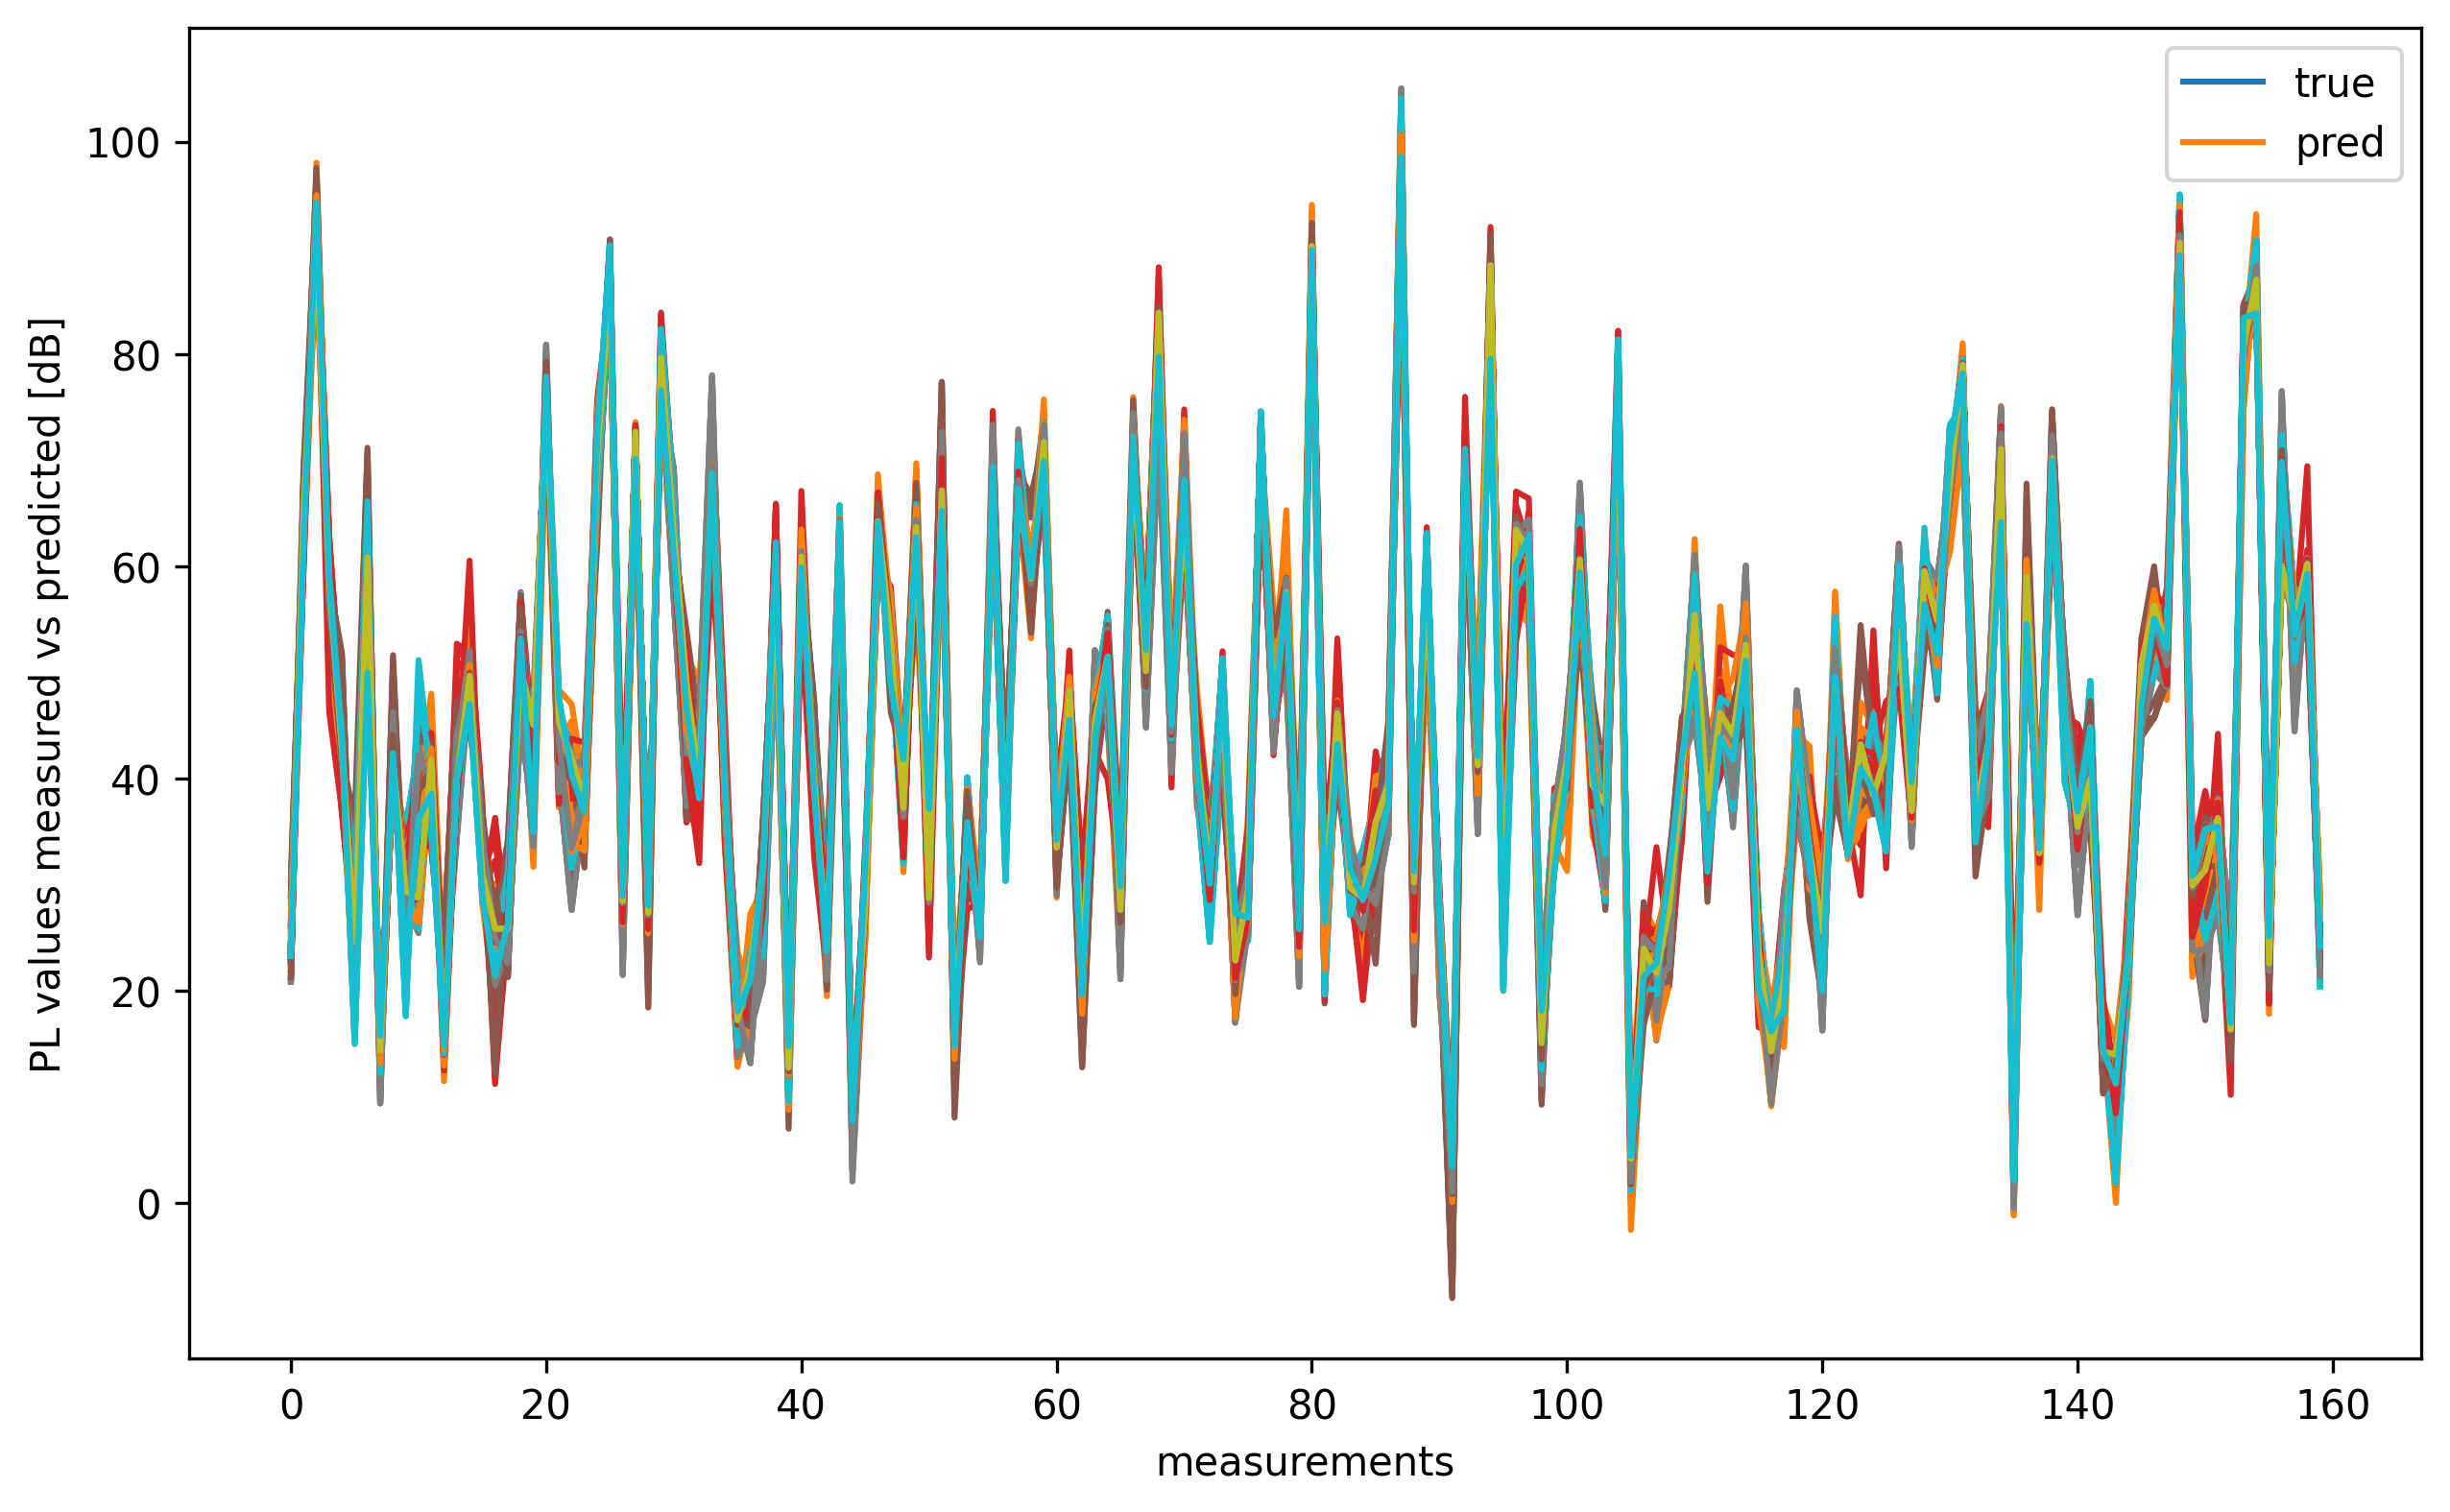

In [51]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.dpi'] = 300


# Store the training and test losses for each grid size for later plotting.
tr_losses = []
te_losses = []
plot_grids = []
plot_steps = []
plot_lambs = []
tr_maes = []
tr_mses = []
tr_mapes = []
tr_r2s = []

train_losses = []
test_losses = []

# Thee parameters for the KAN model.
grids = np.array([5, 8, 10, 15, 20, 30, 40, 50])
steps = np.array([50, 100, 200, 300])
k = 3
lamb = np.array([0.02, 0.002, 0.0002, 0.00002, 0.000002])

for g in range(grids.shape[0]):
    for s in range(steps.shape[0]):
        for l in range(lamb.shape[0]):
            model= KAN(
                width=[6,6,1],
                grid=grids[g], 
                k=3, 
                seed=42, 
                device=device, 
            ) 
            
            print(f"Grid size: {grids[g]}, steps {steps[s]}, {lamb[l]}")
            results = model.fit(dataset, opt="LBFGS", lamb=lamb[l], steps=steps[s])

            if not np.isnan(results['train_loss']).any():
                train_losses += results['train_loss']
                test_losses += results['test_loss']

                tr_mse, tr_rmse, tr_mae, tr_mape, tr_r2 = eval_kan(model, nan, dataset);

                plot_grids.append(grids[g])
                plot_steps.append(steps[s])
                plot_lambs.append(lamb[l])
                print(plot_lambs)
                
                tr_losses.append(np.array(train_losses).mean())
                te_losses.append(np.array(test_losses).mean())
                tr_maes.append(tr_mae)
                tr_mses.append(tr_mse)
                tr_mapes.append(tr_mape)
                tr_r2s.append(tr_r2)


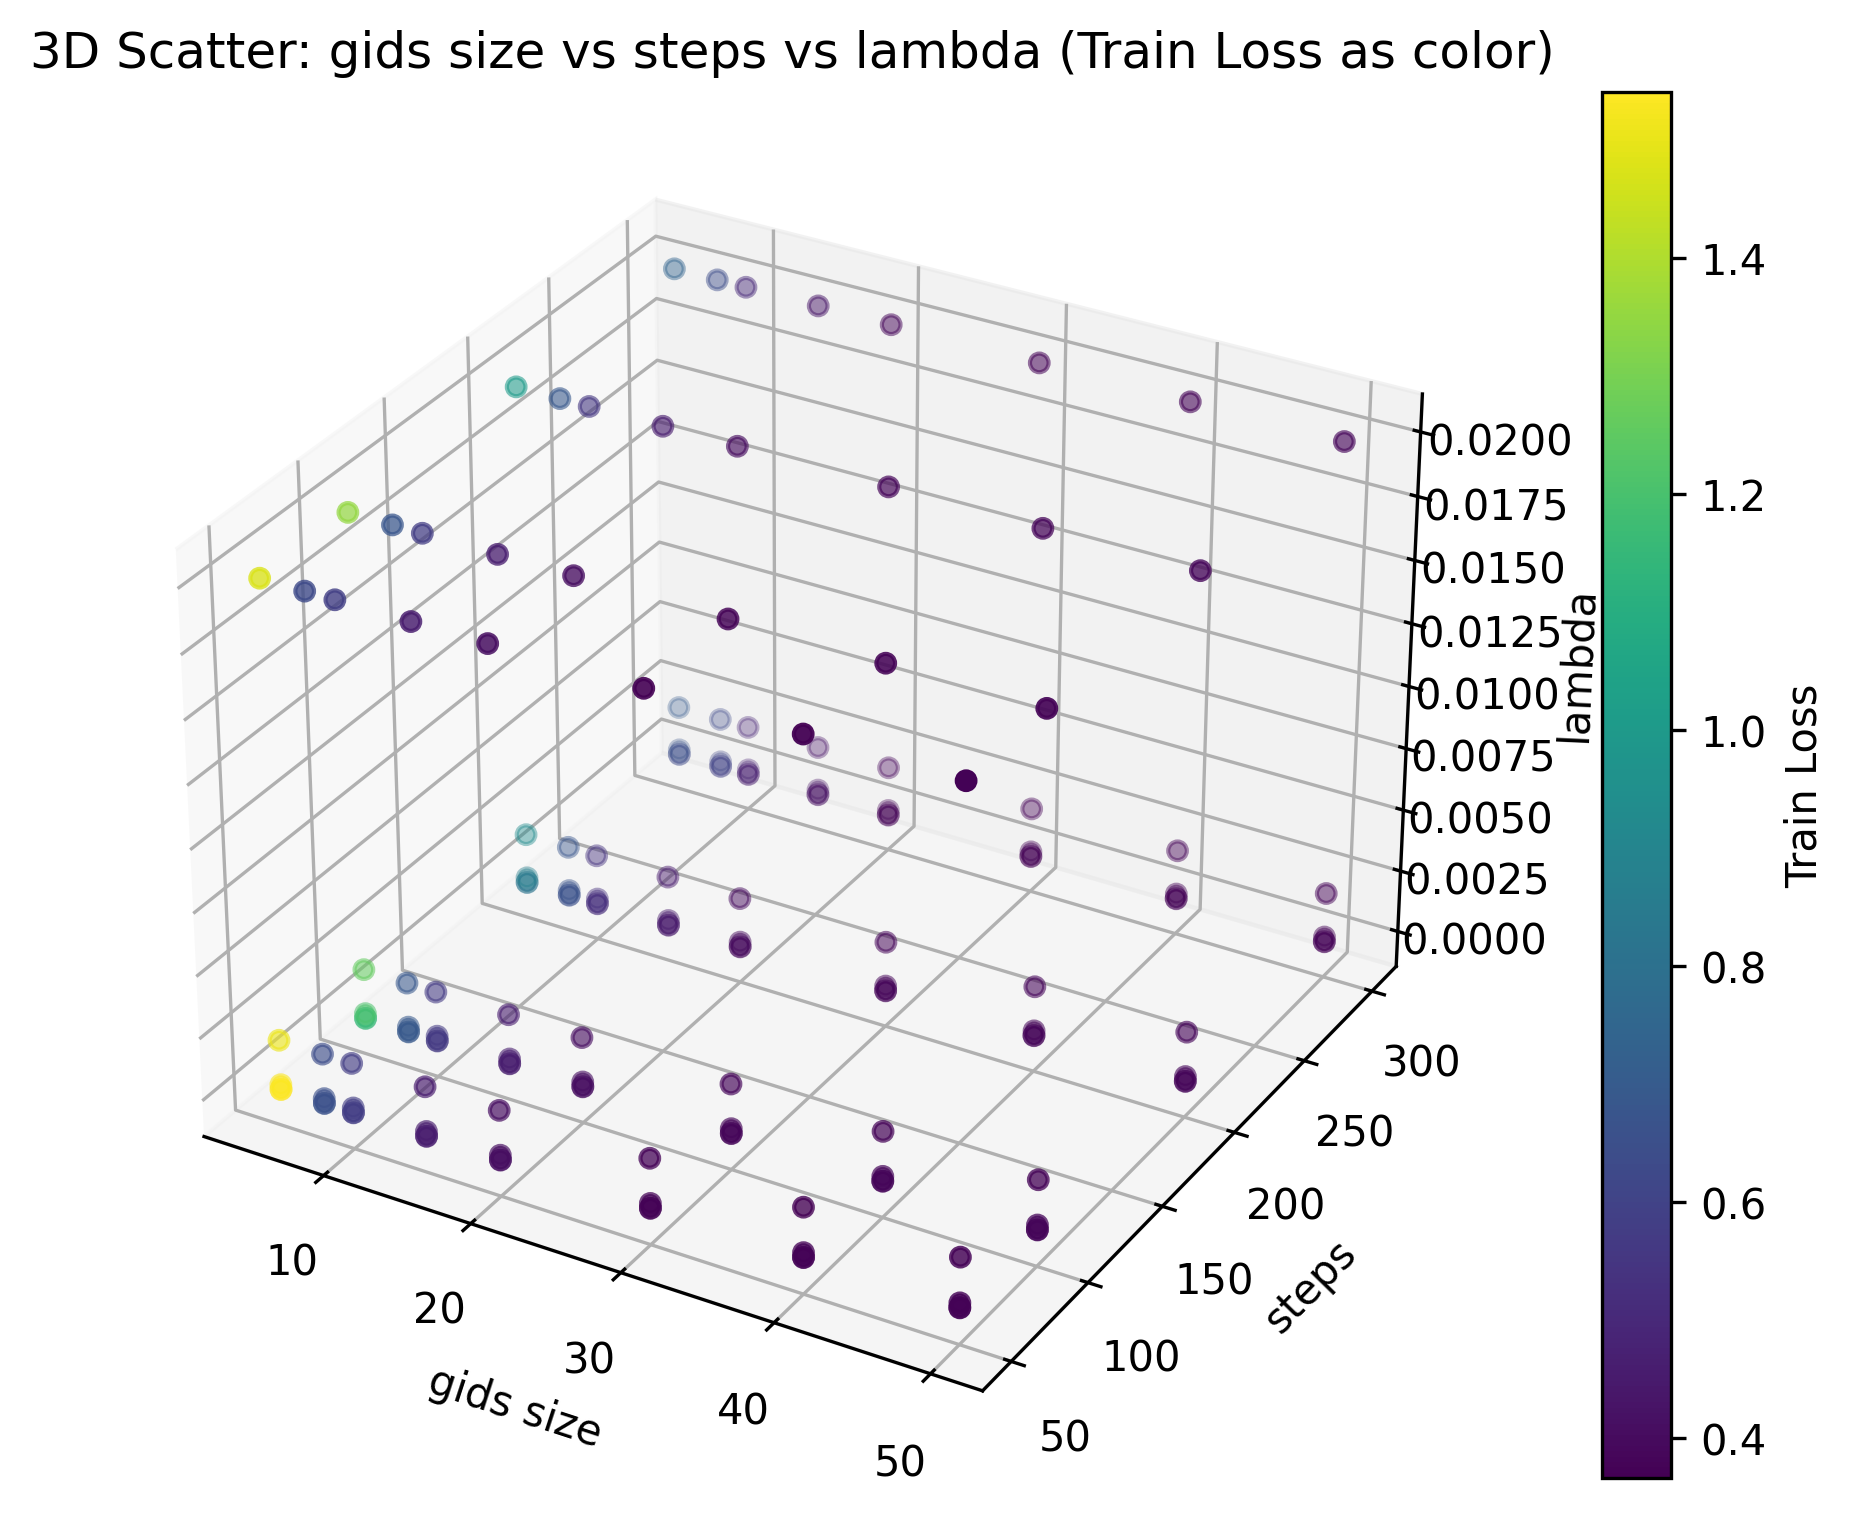

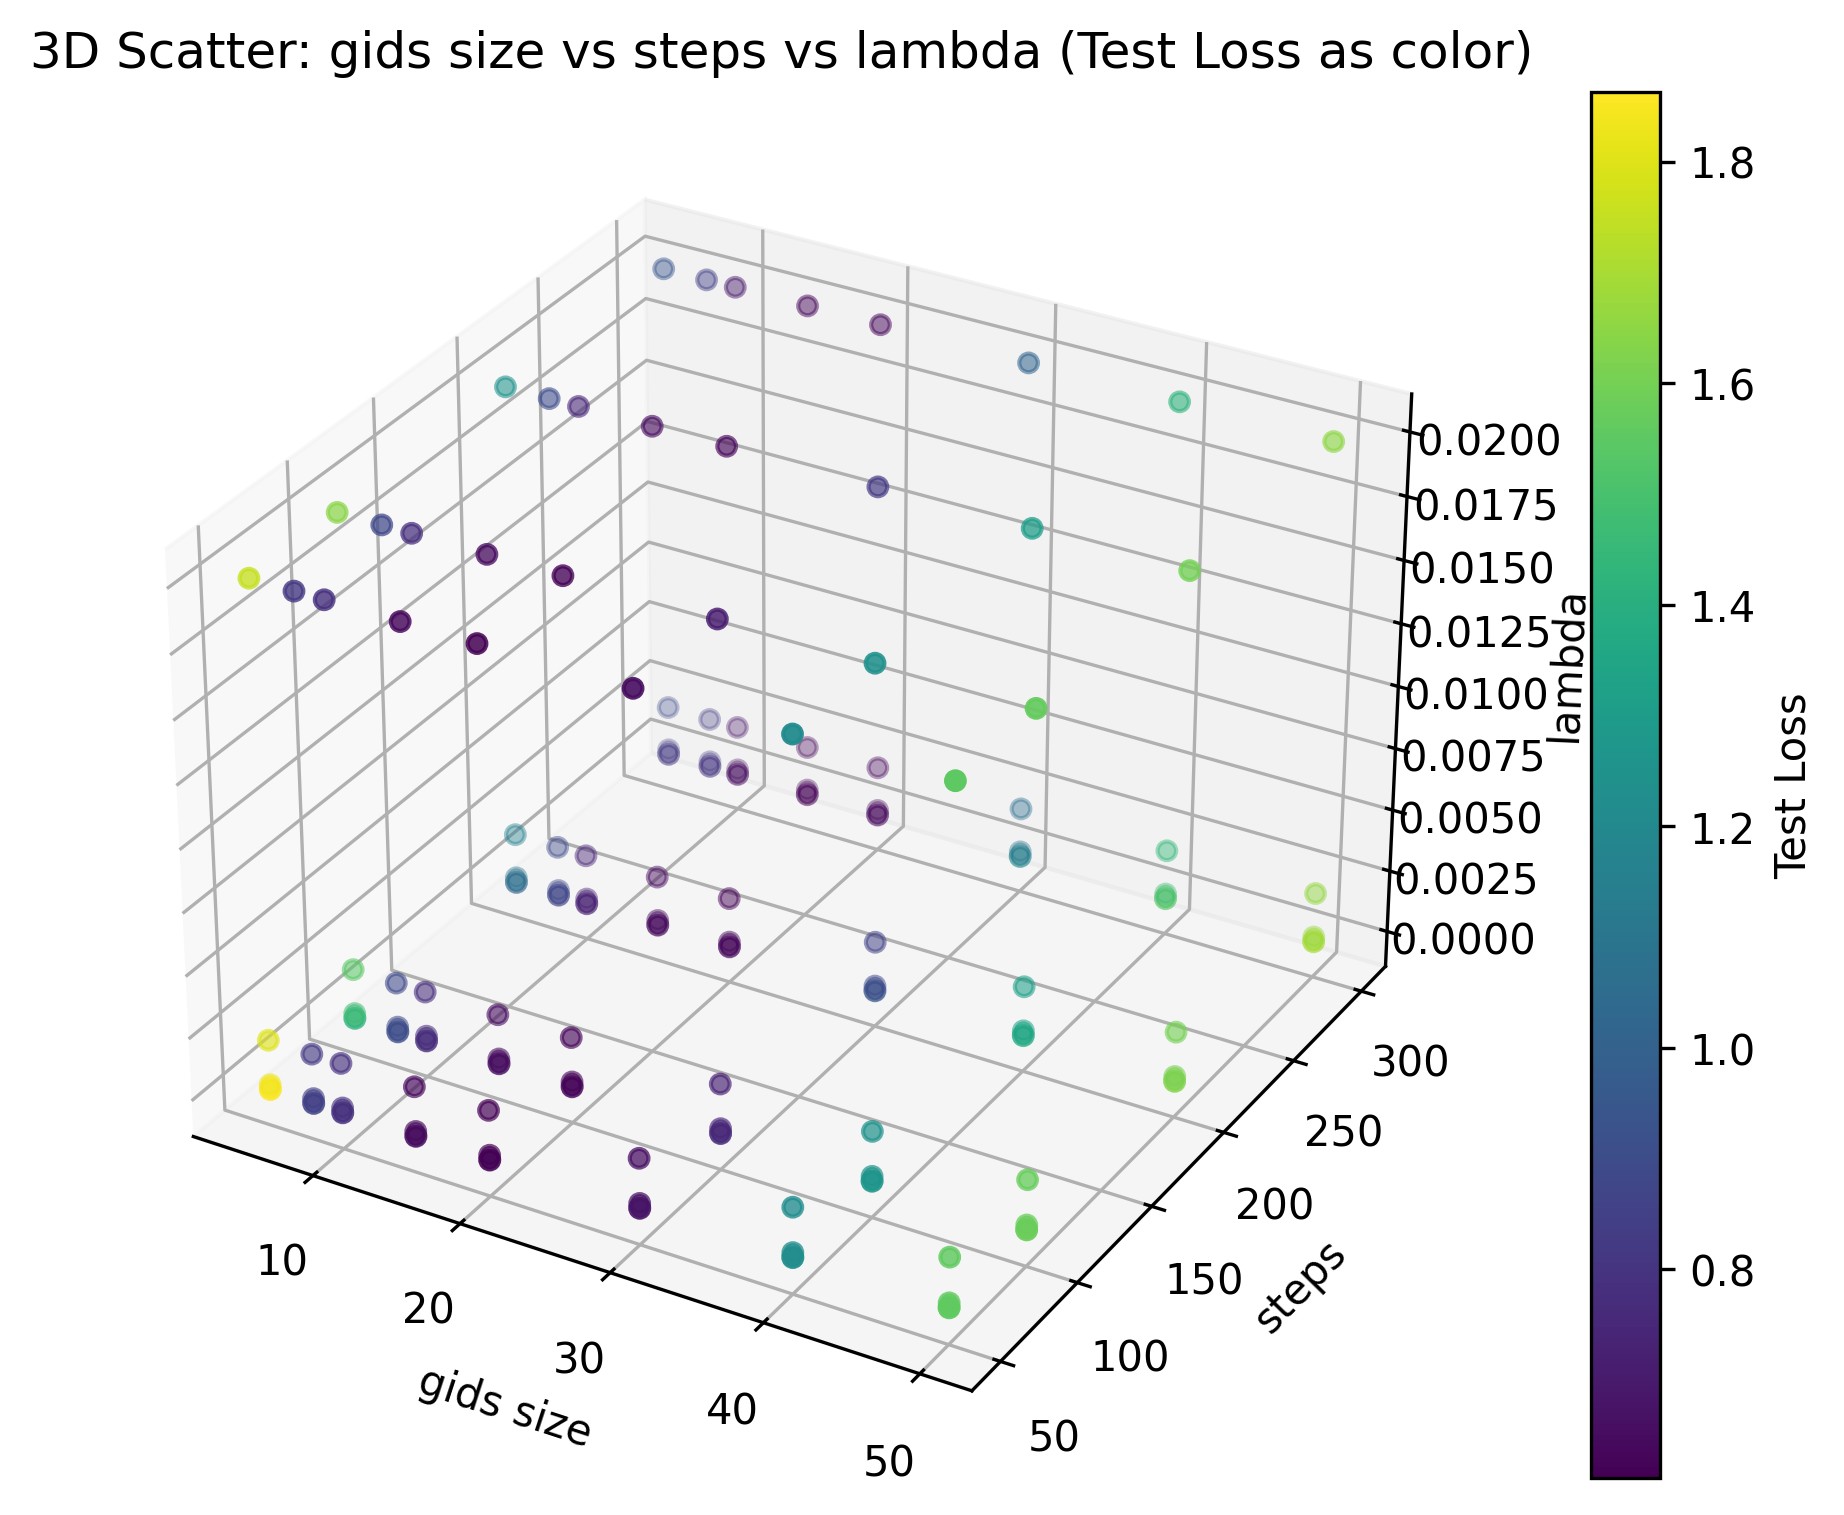

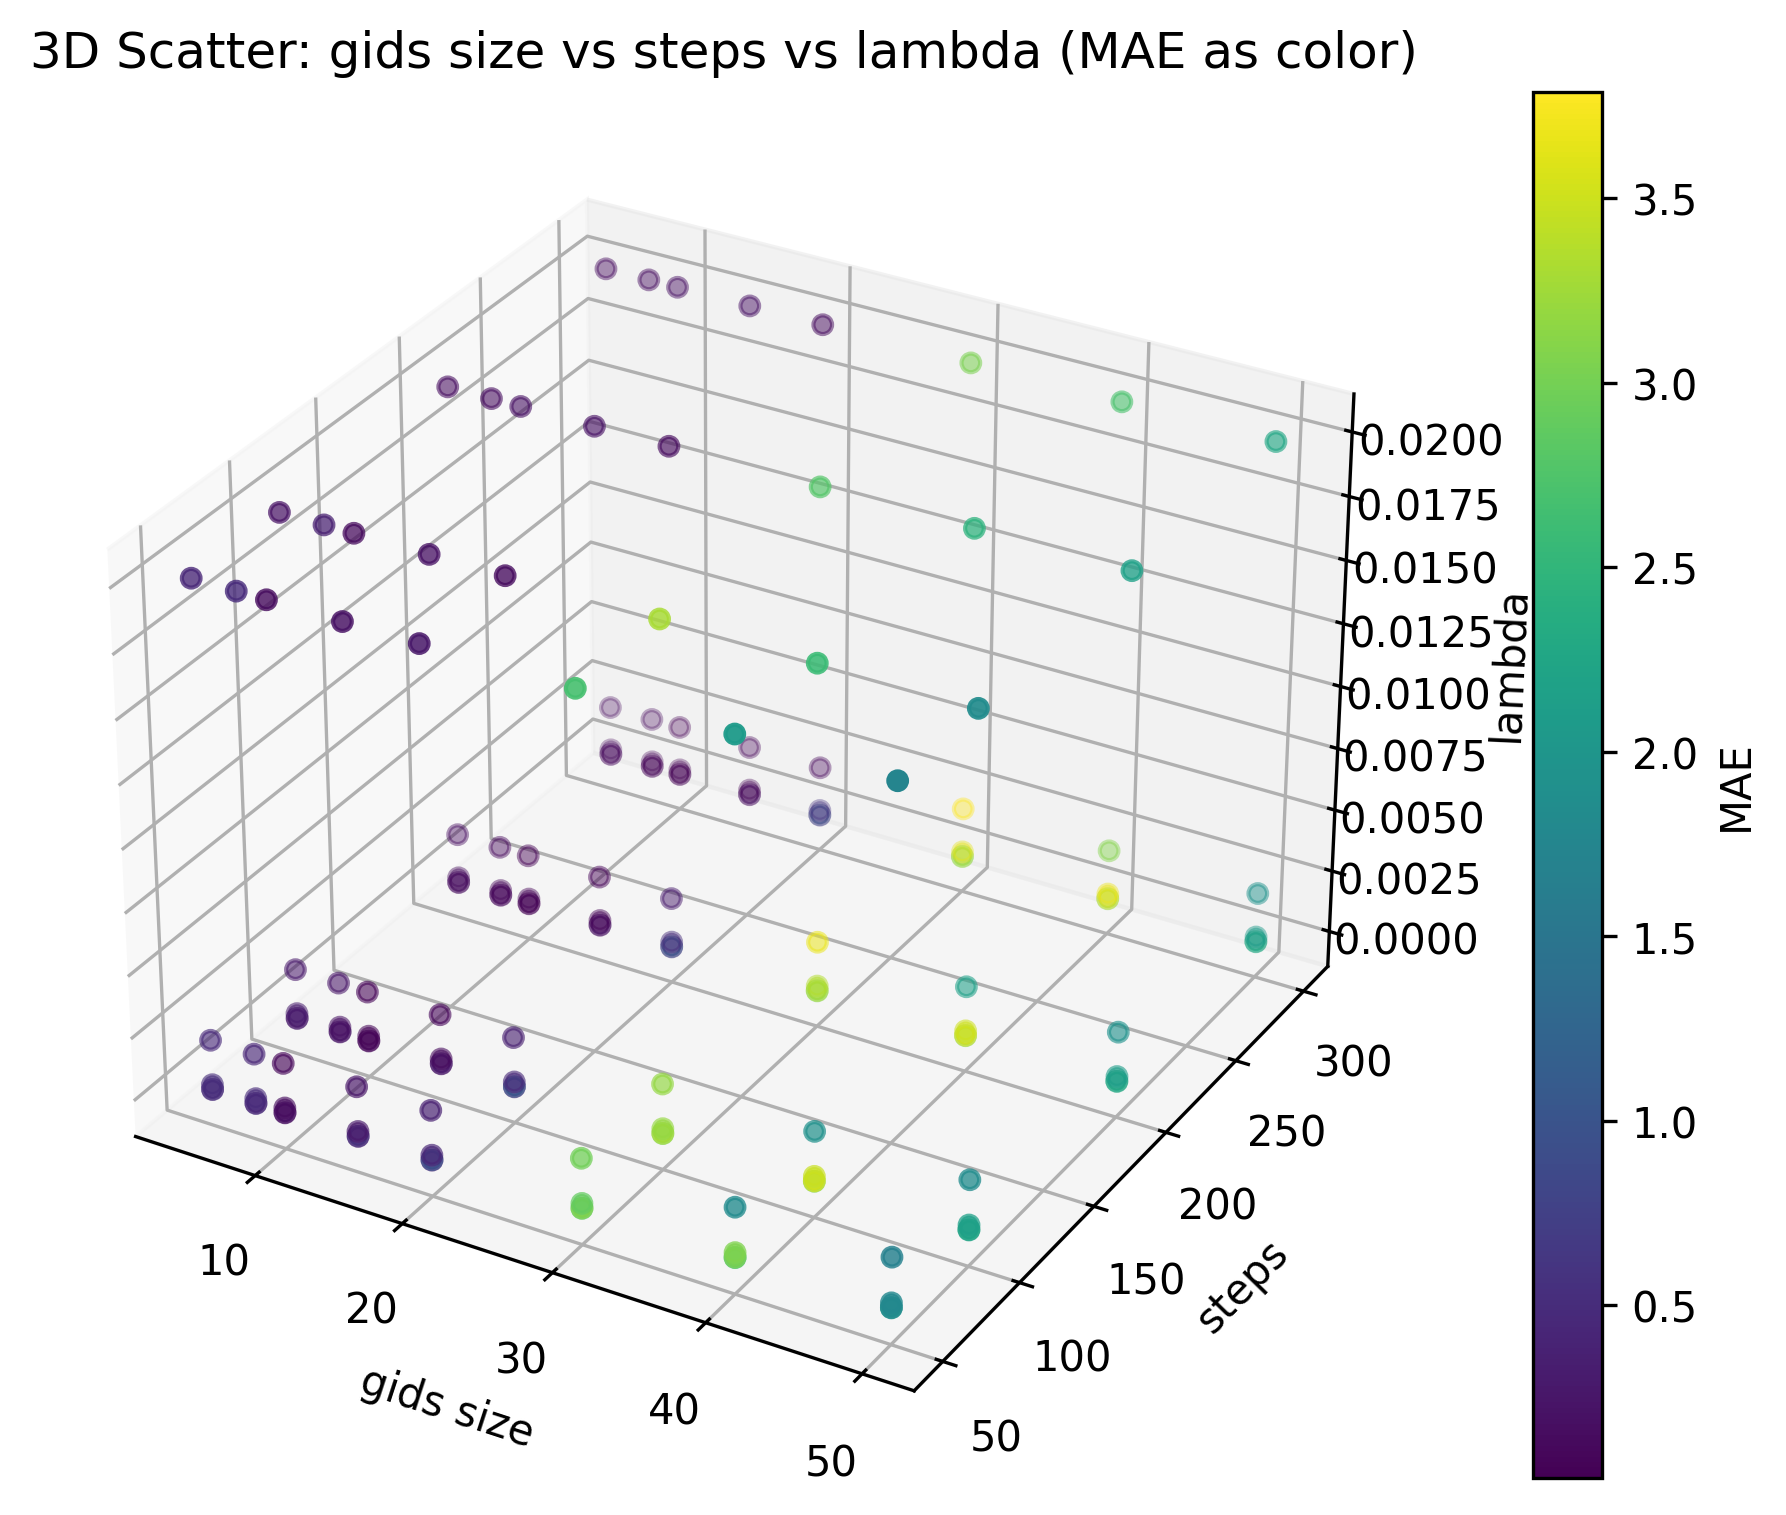

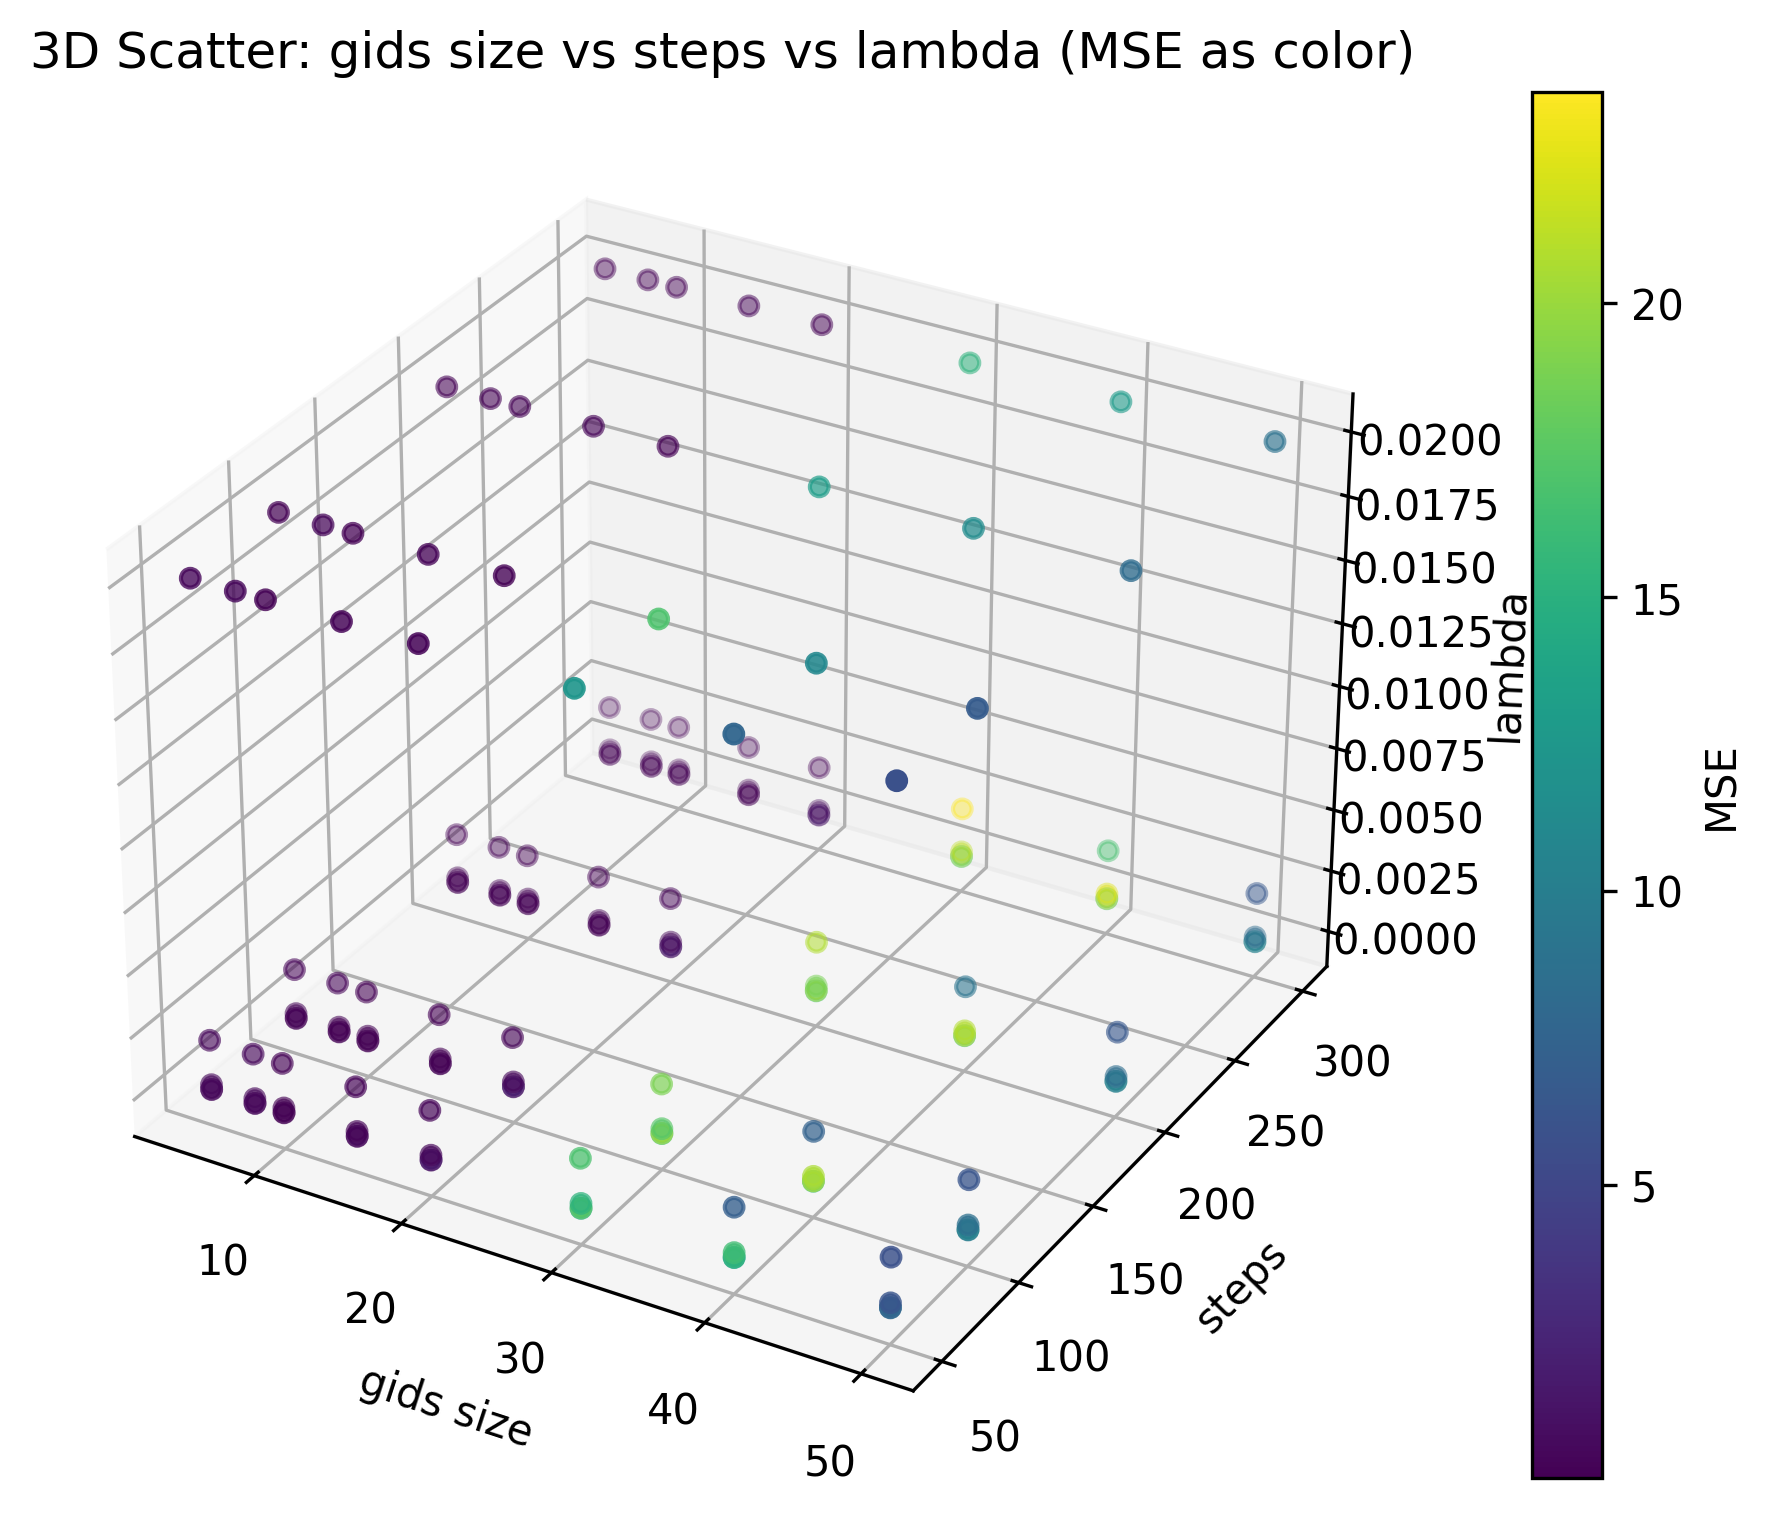

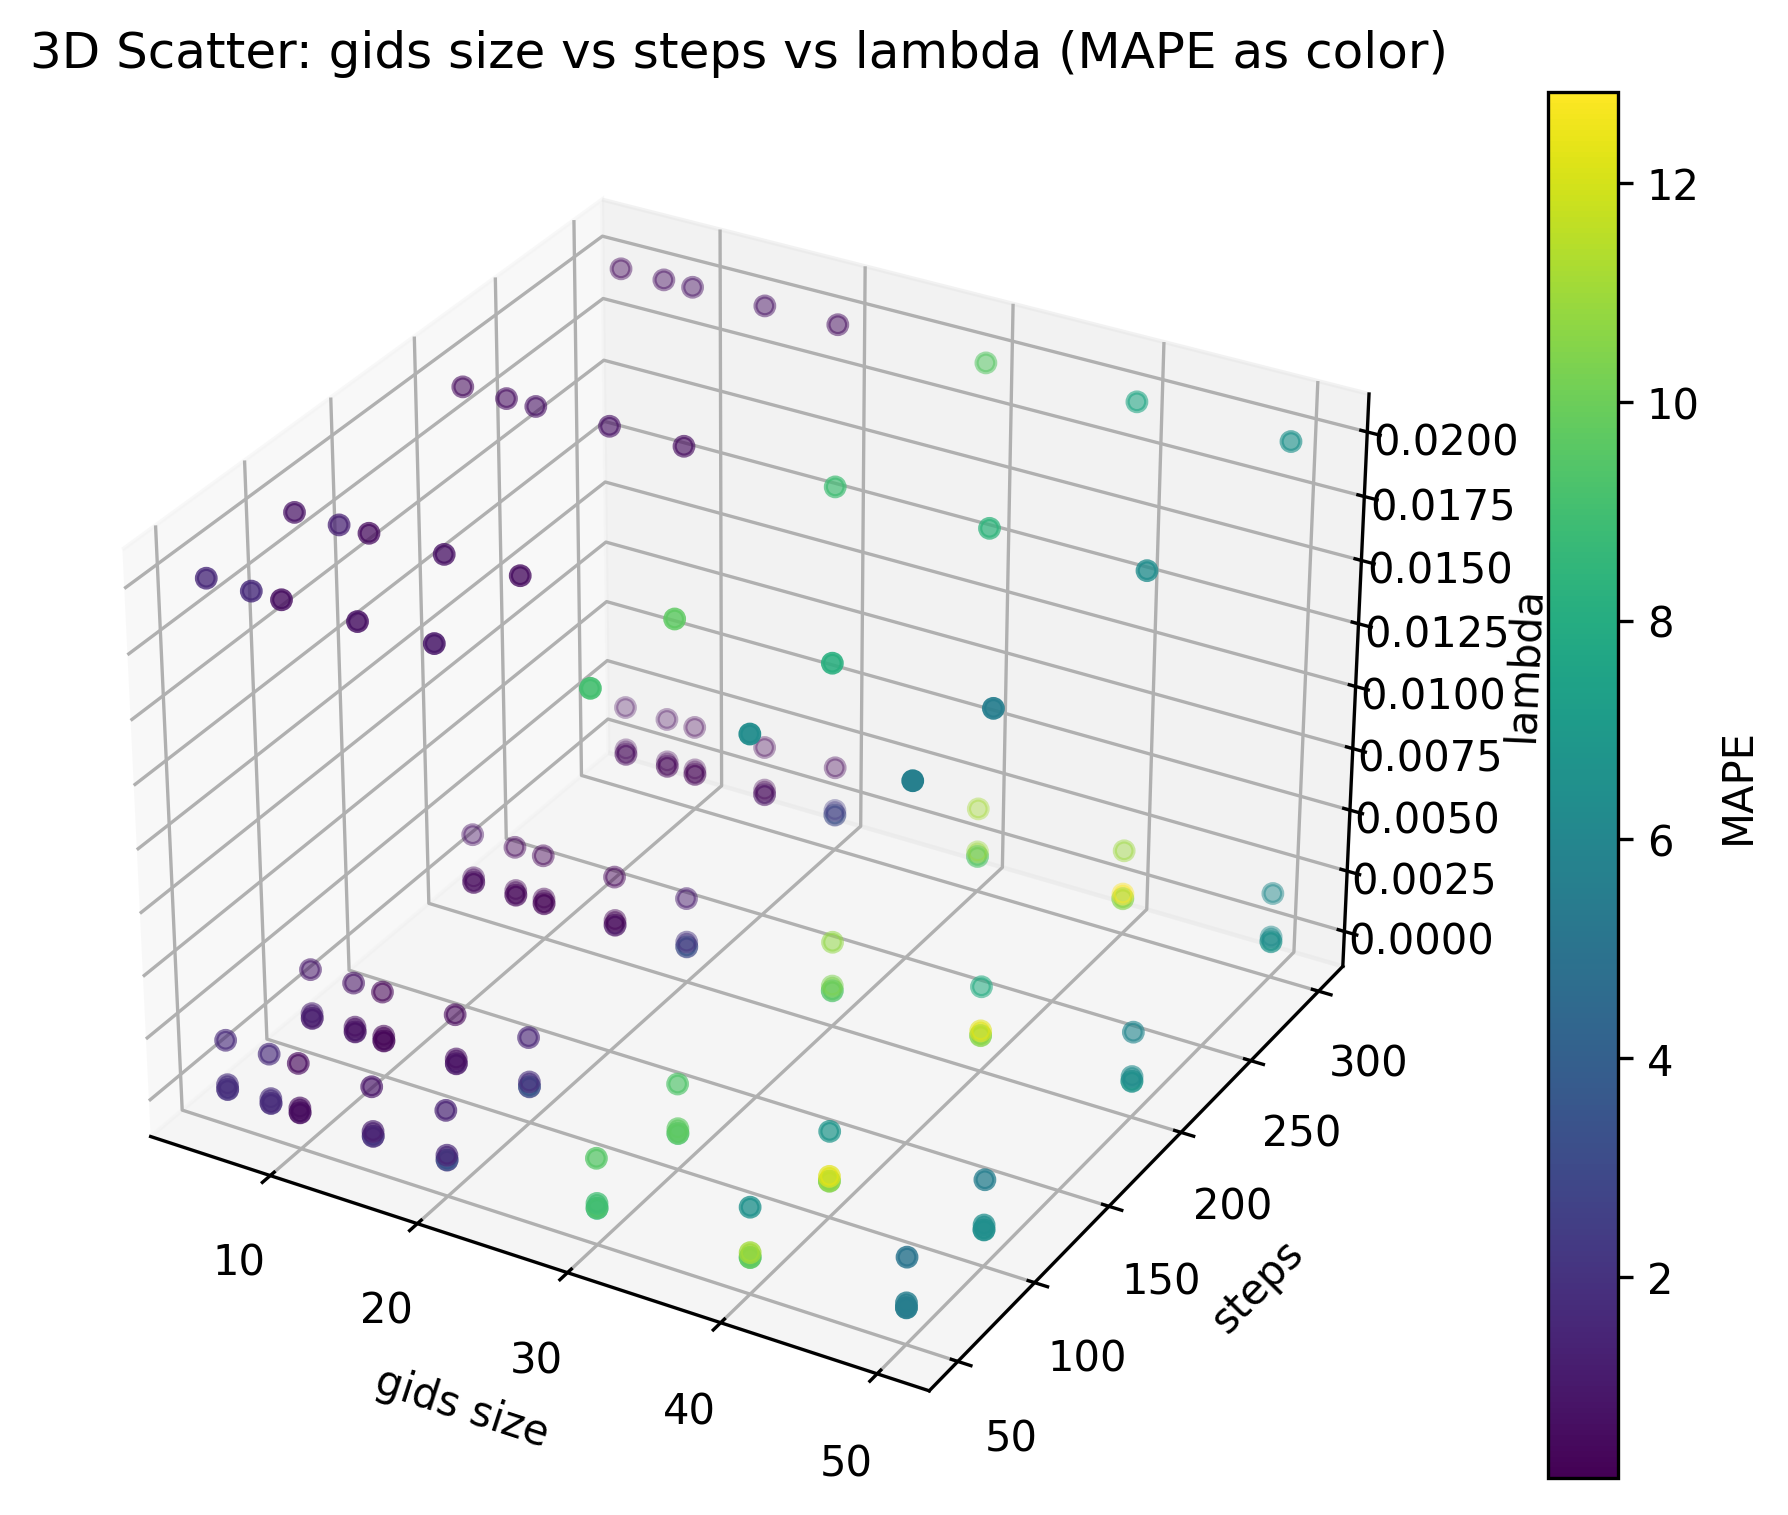

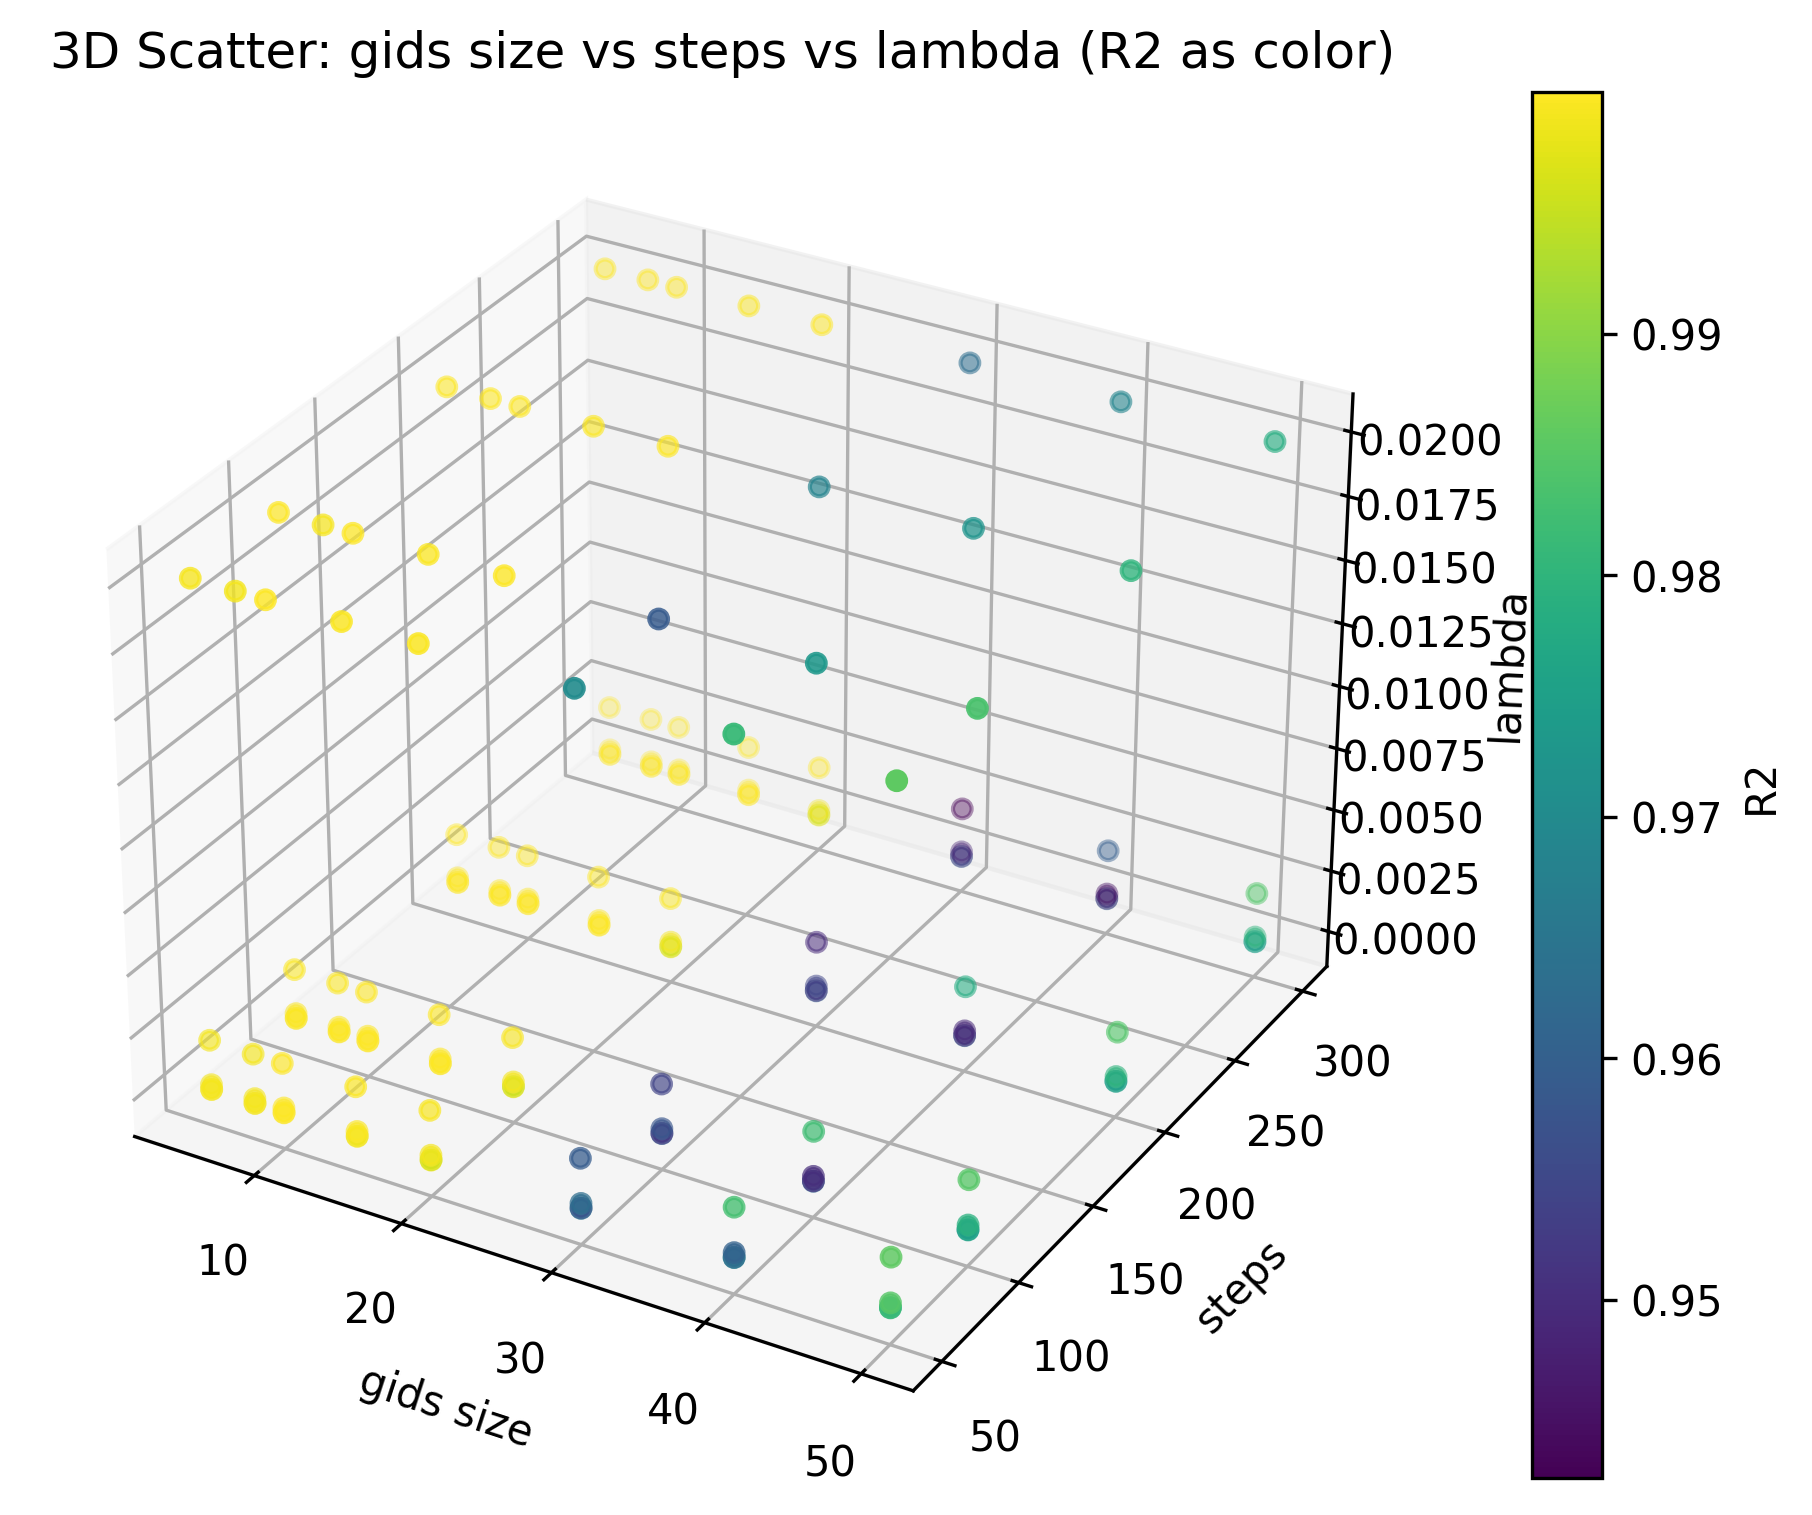

In [52]:
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_losses, "Train Loss")
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, te_losses, 'Test Loss')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_maes, 'MAE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mses, 'MSE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_mapes, 'MAPE')
plot_gids_steps_lambda_loss(plot_grids, plot_steps, plot_lambs, tr_r2s, 'R2')

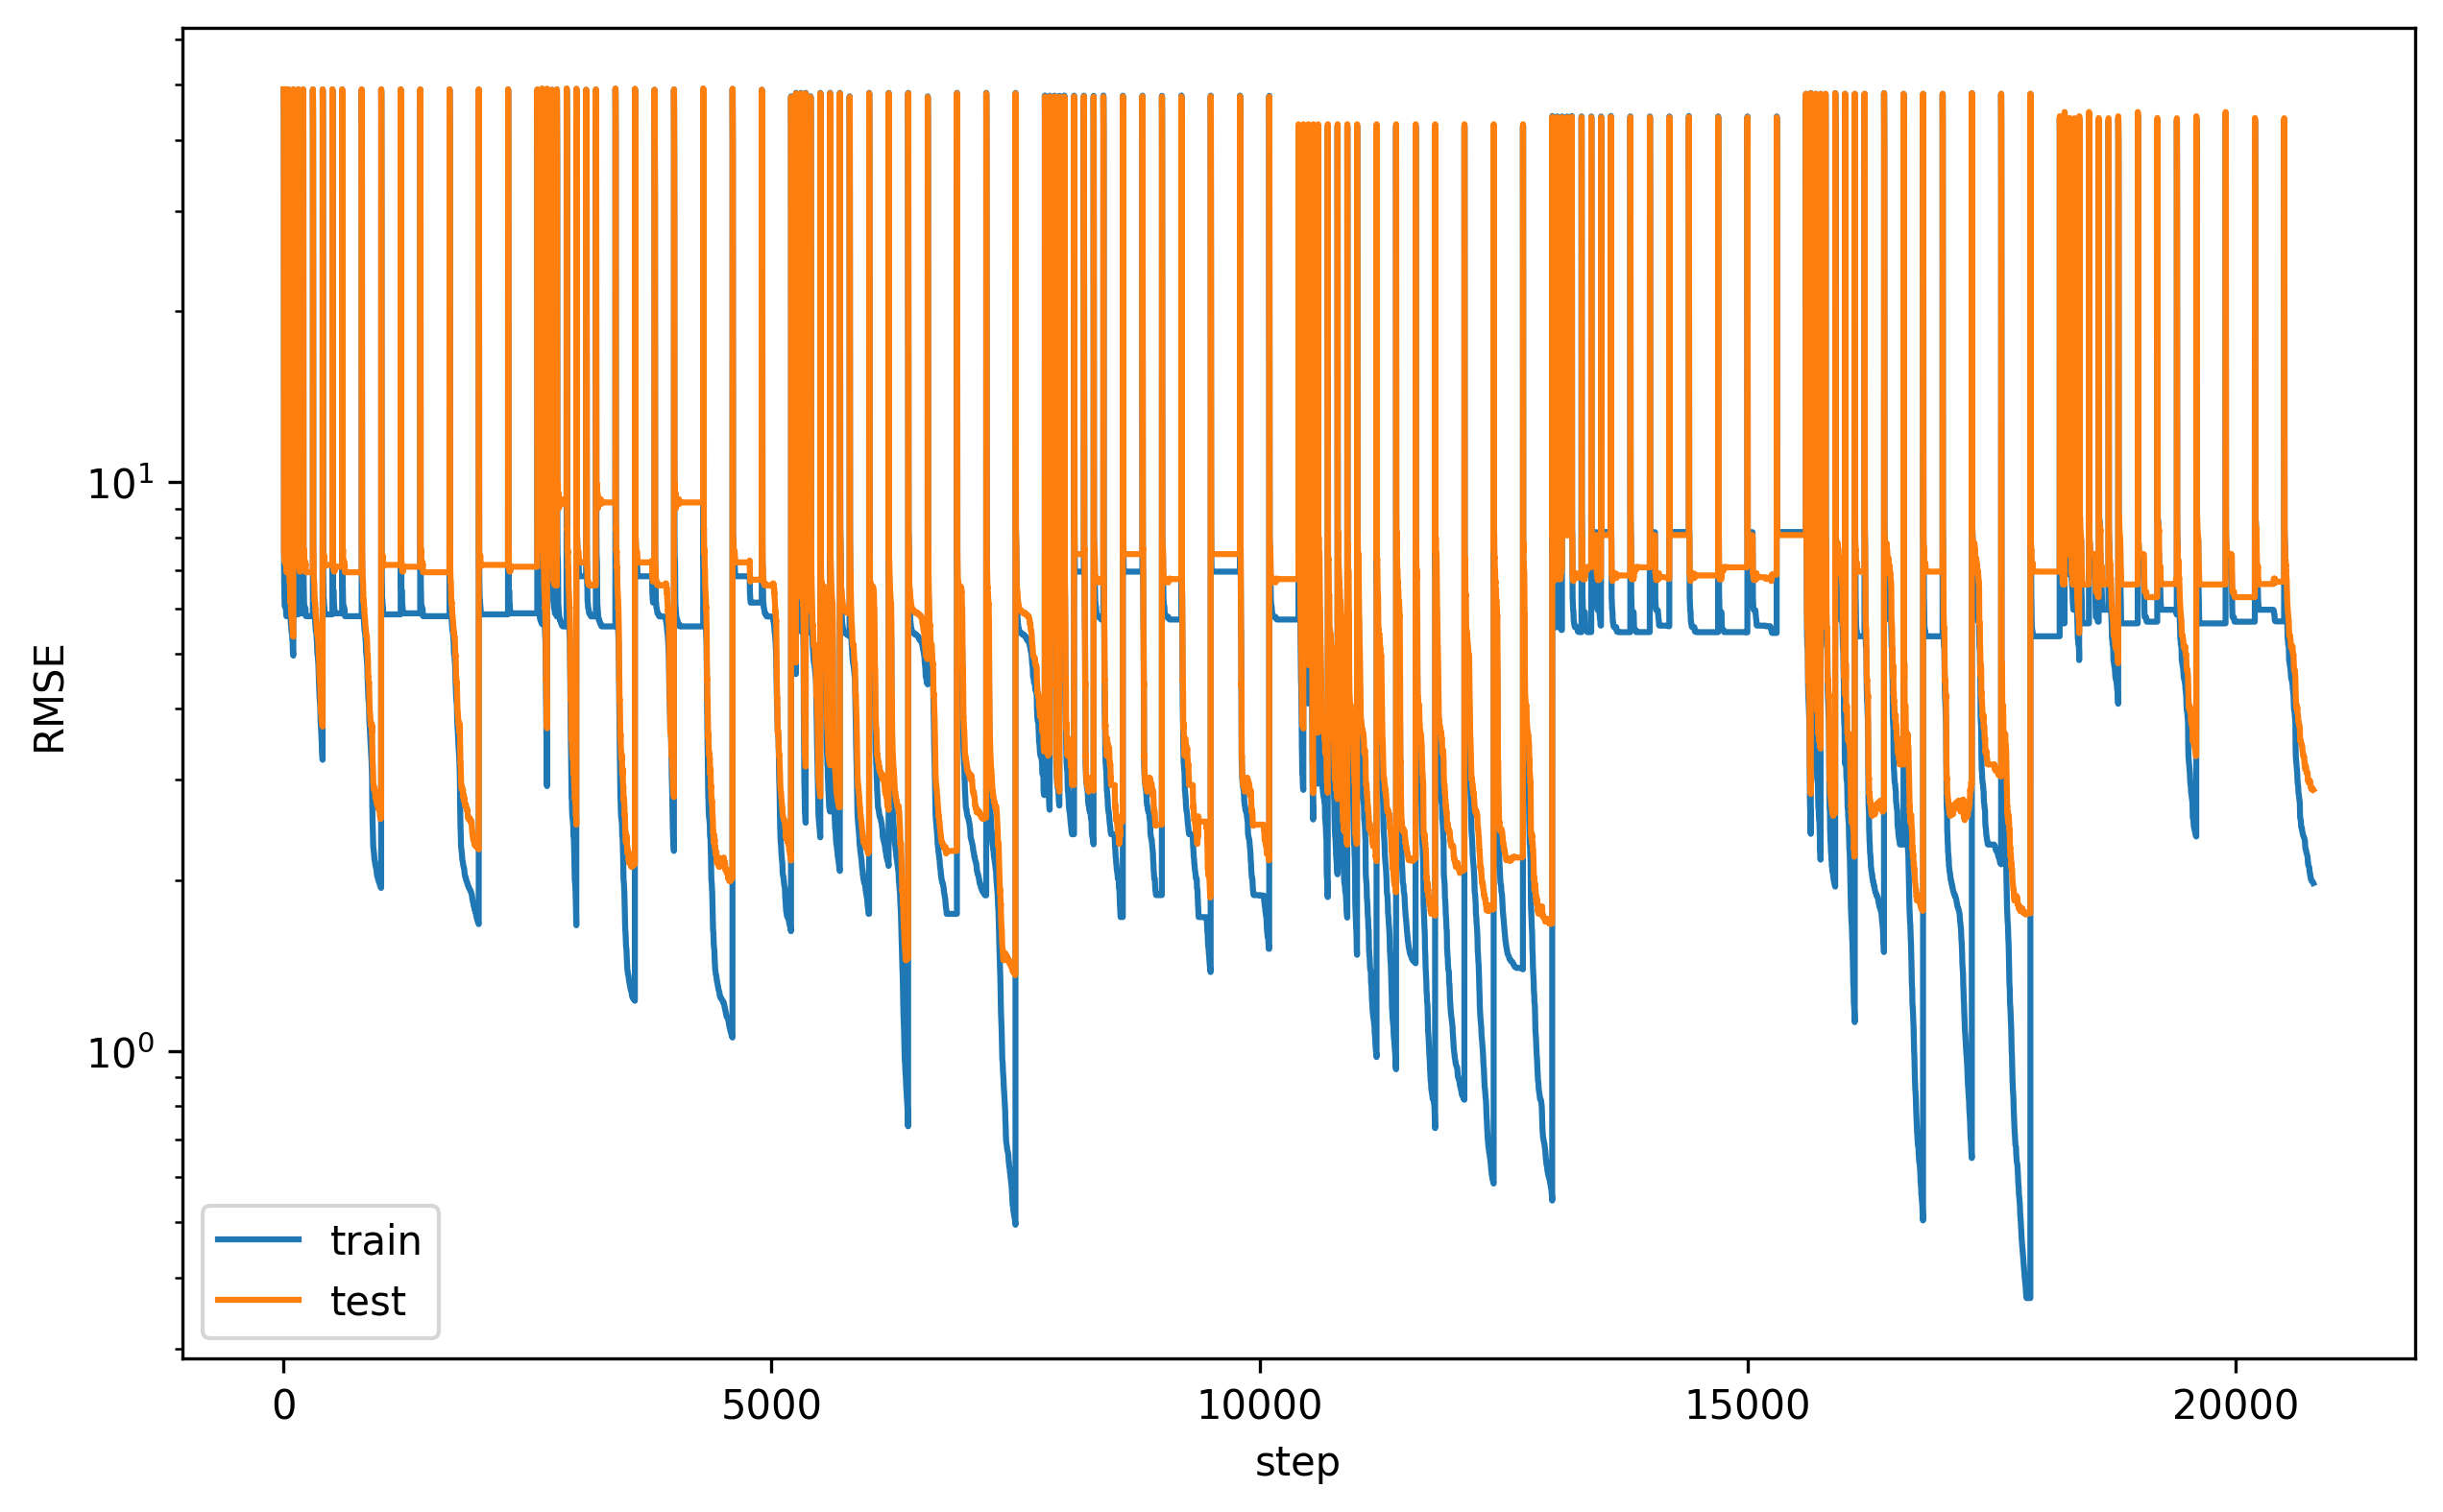

In [ ]:
# Plot the training and test losses.
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')